# Supplemental Notebook
### Input data:
This notebook reads RBN metadata stored in folders `Results20`, `Results50`, `Results100`, and `Results200`, which are merged and stored in `full_RBN_data.csv` with some preprocessing.
Cell Collective network data is also read from the `cc_network_data.csv` file.

The RBN results can be generated using the `PowerLaw_Experiment.py` script. Cell Collective summary data can be generated using the `cc_analysis.py` script.

### Analysis and requirements:
All figures from the accompanying manuscript are reproducible by running this notebook. Additional figures are also produced here to supplement the main text.
This notebook require `panda`, `numpy`, `sklearn`, `scipy`, and `matplotlib` to be installed.

#### We begin by importing various libraries and functions we will need for the analysis.

In [1]:
import pandas as pd
import numpy as np

import itertools

from os import listdir

from sklearn import metrics
from scipy import stats, special

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import CenteredNorm
%matplotlib inline

#### Next, we define various helper functions for preprocessing the data we will import.

In [2]:
def merge_results_frames(df,df2):
    for idx,r in df.iterrows():
        g = r['gamma']
        p = r['bias']
        for col in df.columns:
            if col == 'gamma' or col == 'bias':
                continue
            df.loc[(df['gamma']==g) & (df['bias']==p),col]+=df2.loc[(df2['gamma']==g) & (df2['bias']==p),col]

def str2list(strarray):
    return [float(x) for x in strarray.strip('[] ').split()]

def df_str2list(df):
    for col in df.columns:
        if col == 'gamma' or col == 'bias':
            continue
        df[col] = df[col].apply(str2list)

def expand_shared_properties_in_dict(df):
    dictall = {}
    for _,row in df.iterrows():
        for col in df.columns:
            if col in ['gamma','bias']:
                rowlist = [row[col]]*len(row['Derrida'])
            else:
                rowlist = row[col]
            if col in dictall:
                dictall[col] += rowlist
            else:
                dictall[col] = rowlist.copy()
    return dictall

def append_extra_columns(dictall):
    dfall = pd.DataFrame(dictall)

    dfall['entropy'] = -(dfall['bias']*np.log2(dfall['bias']))-((1-dfall['bias'])*np.log2(1-dfall['bias']))
    dfall['variance'] = dfall['bias']*(1-dfall['bias'])

    dfall['avgS']=dfall['avgKe']-dfall['avgKc']
    dfall['regime']=(dfall['Derrida']>1).astype(int) - (dfall['Derrida']<1).astype(int)
    dfall['avgH'] = -dfall['avgP']*np.log2(dfall['avgP'])-(1-dfall['avgP'])*np.log2(1-dfall['avgP'])
    dfall['avgV'] = (1-dfall['avgP'])*dfall['avgP']
    
    return dfall

#### We now import the RBN data.
Note that the variable `REGENERATE_DATA` determines whether the data will be read from the individual results folder to create a new `full_RBN_data.csv` file (if `True`) or read from from a previously assembled `full_RBN_data.csv` file (if `False`).

In [3]:
REGENERATE_DATA=False # takes a couple of minutes to regenerate data frame from individual csv files

results_dir_dict={20:'Results20/',50:'Results50/',100:'Results100/',200:'Results200/'}
if REGENERATE_DATA:
    results_dir_dict={20:'Results20/',50:'Results50/',100:'Results100/',200:'Results200/'}
    dfall = pd.DataFrame()
    for N,results_dir in results_dir_dict.items():
        first_in_N = True
        for filename in listdir(results_dir):
            if first_in_N:
                df = pd.read_csv(results_dir+filename)
                df_str2list(df)
                first_in_N = False
            else:
                df2 = pd.read_csv(results_dir+filename)
                df_str2list(df2)
                merge_results_frames(df,df2)
        dictall = expand_shared_properties_in_dict(df)
        dfallN = append_extra_columns(dictall)
        dfallN['N']=N
        dfall = pd.concat([dfall,dfallN],axis=0)
    dfall.to_csv('full_RBN_data.csv')           
else:
    dfall=pd.read_csv('full_RBN_data.csv')
Nvals = results_dir_dict.keys()
dfall['gamma'] = dfall['gamma'].round(2) # to fix some entries recorded, e.g., like 2.100000005
dfall['bias'] = dfall['bias'].round(2)
# shuffle data
dfall=dfall.sample(frac=1.0)

dfall

Unnamed: 0  gamma  bias  Derrida   avgK  medK     avgKe  medKe  \
22576        22576    2.1  0.15    0.609  2.550   1.0  1.229603   0.00   
36319          319    1.5  0.05    0.284  3.560   3.0  1.054807   0.00   
31792        31792    2.3  0.40    1.084  2.100   1.0  1.430023   1.00   
117700        9700    1.7  0.35    1.240  2.775   1.0  1.760040   1.00   
129588       21588    2.0  0.45    1.083  2.265   1.0  1.416691   1.00   
...            ...    ...   ...      ...    ...   ...       ...    ...   
132700       24700    2.1  0.40    0.937  1.960   1.0  1.197584   1.00   
79890         7890    1.7  0.10    0.405  2.400   1.0  0.844950   0.00   
21073        21073    2.0  0.40    1.054  2.100   1.5  1.255344   1.00   
94945        22945    2.1  0.20    0.691  2.160   1.0  1.078037   0.00   
53268        17268    1.9  0.40    1.328  2.760   2.0  1.870496   1.25   

           avgKc  medKc      avgP   entropy  variance      avgS  regime  \
22576   0.623041    0.0  0.147132  0.609840    0.1275  0.606561      -1   
36319   0.734783    0.0  0.051222  0.286397    0.0475  0.320024      -1   
31792   0.316937    0.0  0.409836  0.970951    0.2400  1.113086       1   
117700  0.521678    0.0  0.349674  0.934068    0.2275  1.238362       1   
129588  0.337092    0.0  0.453282  0.992774    0.2475  1.079600       1   
...          ...    ...       ...       ...       ...       ...     ...   
132700  0.222173    0.0  0.404415  0.970951    0.2400  0.975411      -1   
79890   0.462382    0.0  0.102294  0.468996    0.0900  0.382568      -1   
21073   0.236594    0.0  0.372093  0.970951    0.2400  1.018750       1   
94945   0.382500    0.0  0.202951  0.721928    0.1600  0.695537      -1   
53268   0.473616    0.0  0.399940  0.970951    0.2400  1.396880       1   

            avgH      avgV    N  
22576   0.602616  0.125484   20  
36319   0.291564  0.048598   50  
31792   0.976414  0.241870   20  
117700  0.933776  0.227402  200  
129588  0.993693  0.247817  200  
...          ...       ...  ...  
132700  0.973475  0.240864  200  
79890   0.476226  0.091830  100  
21073   0.952266  0.233640   20  
94945   0.727792  0.161762  100  
53268   0.970915  0.239988   50  

[144000 rows x 18 columns]

#### We define a helper function for finding the critical boundary.
The thermodynamic critical boundary depends upon the average in-degree. We therefore define a function to calculate this mean (in the thermodynamic limit) from the generateing parameter `gamma` ($\gamma$) assuming a truncated power-law distribution with exponent $\gamma$ and cutoff $m$ (here explicitly called `cutoff`).

In [4]:
def kmean(gamma,cutoff=None):
    if cutoff is None:
        return special.zeta(gamma-1)/special.zeta(gamma)
    else:
        ks = np.arange(1,cutoff+1).astype(float)
        return np.sum(ks**(1-gamma)) / np.sum(ks**(-gamma))

#### We explore how finite-size effects influence the critical boundary.
The figures produced here show the fraction of networks for each sampled point in parameter space that have Derrida coefficients ($\delta$) greater than $1$ (chaotic, in red) or less than $1$ (ordered, in blue). Bold outlined points have at least a $15-85\%$ split between ordered and chaotic networks. These allow us to visualize a "fuzzy" critical boundary for various sizes of networks.

C:\Users\jcroz\AppData\Local\Temp\ipykernel_42544\4043581813.py:8: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xrange,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xrange],'k--')


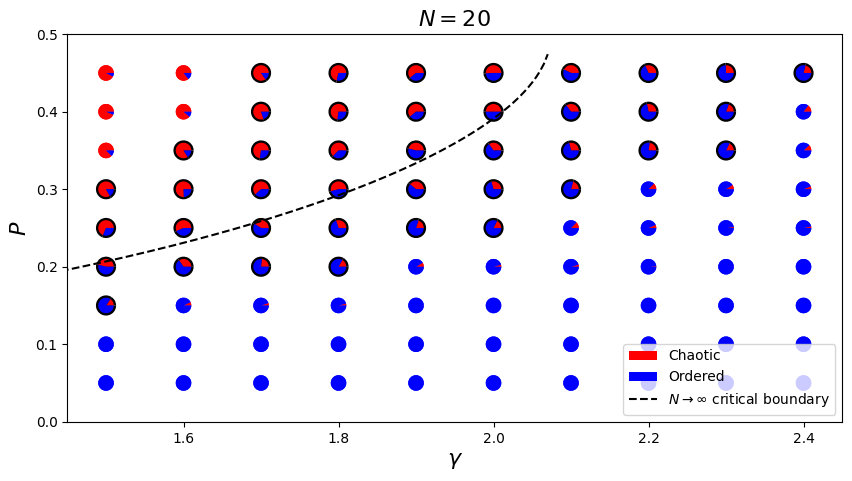

C:\Users\jcroz\AppData\Local\Temp\ipykernel_42544\4043581813.py:8: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xrange,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xrange],'k--')


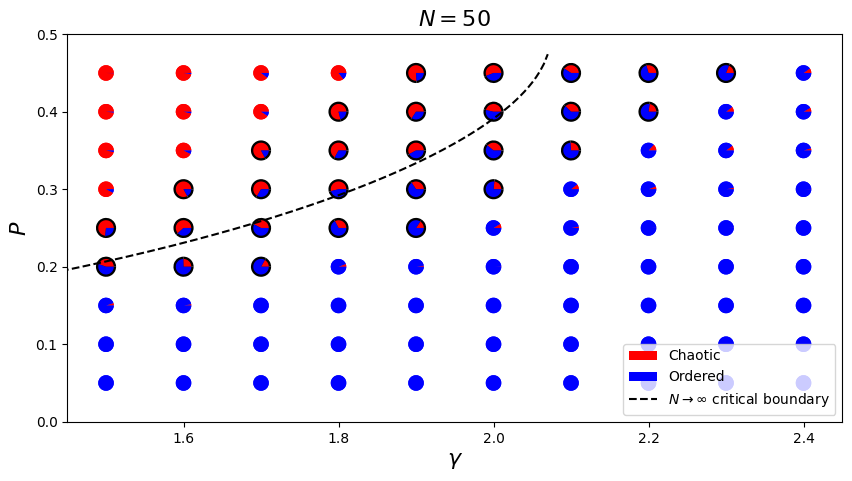

C:\Users\jcroz\AppData\Local\Temp\ipykernel_42544\4043581813.py:8: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xrange,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xrange],'k--')


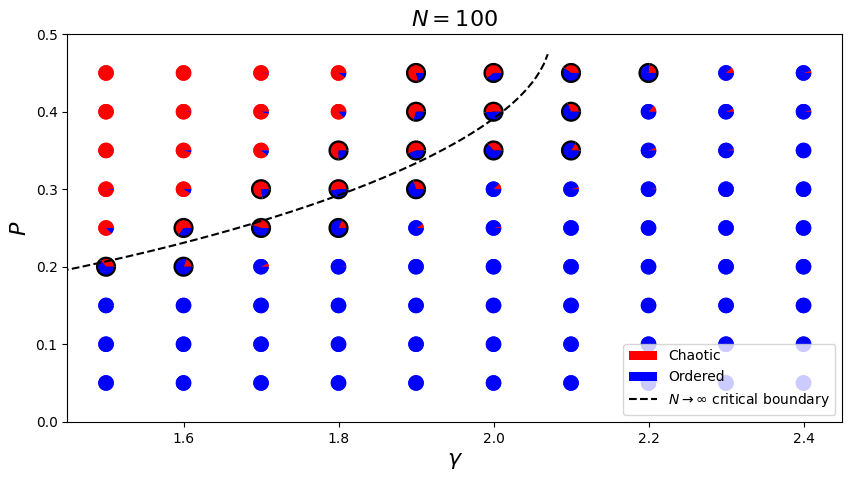

C:\Users\jcroz\AppData\Local\Temp\ipykernel_42544\4043581813.py:8: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(xrange,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xrange],'k--')


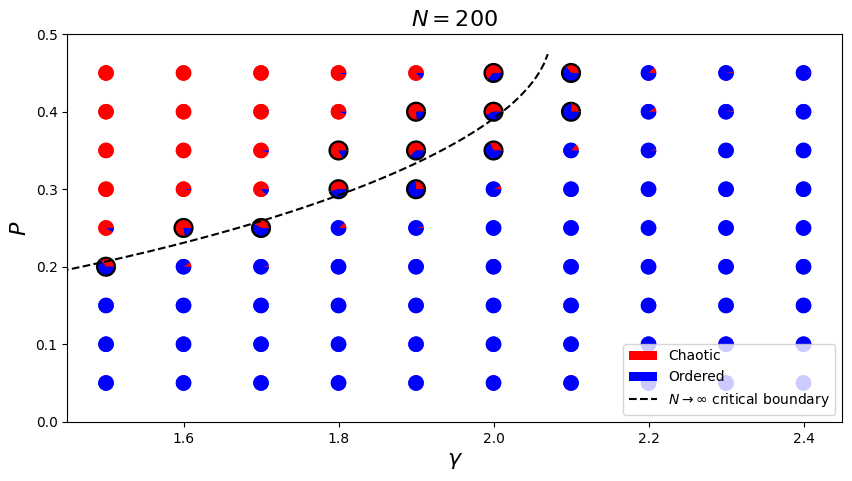

In [5]:
biases = np.arange(0.05,0.5,0.05).round(2)
gammas = np.arange(1.5,2.5,0.1).round(2)
fs=16
for N in Nvals:
    fig, ax = plt.subplots(figsize=(10, 10),facecolor='white')
    
    xrange = np.arange(1.4, 2.6, 0.005)
    ax.plot(xrange,[0.5-0.5*np.sqrt(1-2/kmean(xg,cutoff=15)) for xg in xrange],'k--') 
    
    for g,p in itertools.product(gammas,biases):
        g=g.round(2)
        p=p.round(2)
        ones = (dfall[(dfall['N'] == N) & (dfall['gamma'] == g) & (dfall['bias'] == p)]['Derrida']>1).mean()
        ax.pie([ones, 1-ones], center=(g, p), radius=0.01, colors=['r', 'b'], frame=True)
        if ones > 0.85 or ones < 0.15:
            ax.pie([ones, 1-ones], center=(g, p), radius=0.01, colors=['r', 'b'], frame=True)
        else:
            ax.pie([ones, 1-ones], center=(g, p), radius=0.013, colors=['k', 'k'], frame=True)
            ax.pie([ones, 1-ones], center=(g, p), radius=0.01, colors=['r', 'b'], frame=True)
        ax.set_xlim(1.45,2.45)
        ax.set_ylim(0,0.5)
        #ones = [derrida > 1 for derrida in row['Derrida']]
        

    legend_elements = [Patch(facecolor='r', label='Chaotic'), Patch(facecolor='b', label='Ordered'), Line2D([0],[0],color='k',linestyle='--',label=r'$N\rightarrow\infty$ critical boundary')]
    plt.title(f'$N=${N}',fontsize=fs)
    plt.xlabel('$\gamma$',fontsize=fs)
    plt.ylabel('$P$',fontsize=fs)
    ax.legend(handles=legend_elements, loc='lower right')
    plt.savefig(f'figures/PieChartFigure_{N}.pdf',bbox_inches='tight')
    plt.savefig(f'figures/PieChartFigure_{N}.png',bbox_inches='tight')
    plt.show()
    

#### We consider various ways to fit the critical boundary.
We begin by defining the functional forms we will attempt to fit to and associated helper functions.

In [6]:
from scipy.optimize import curve_fit
def powerlaw(x,c,m,b):
    return c*x**m + b

def linear_law(x, m, b):
    return m*x + b

def critical_kappa(rho,c,m,b):
    return (1/rho)*((1-b)/c)**(1/m)

def critical_kappa_lin(rho,m,b):
    return (1-b)/(m*rho)

def mse(x,y,f):
    return np.nanmean((f(x)-y)**2)

#### We fit power law functions to the critical boundary in RBNs.
As described in the main text, we fit $\sigma^2 k$, $\sigma^2 k_e$, and $H k_e$ to $\delta$ using a power law function for various sizes of network.

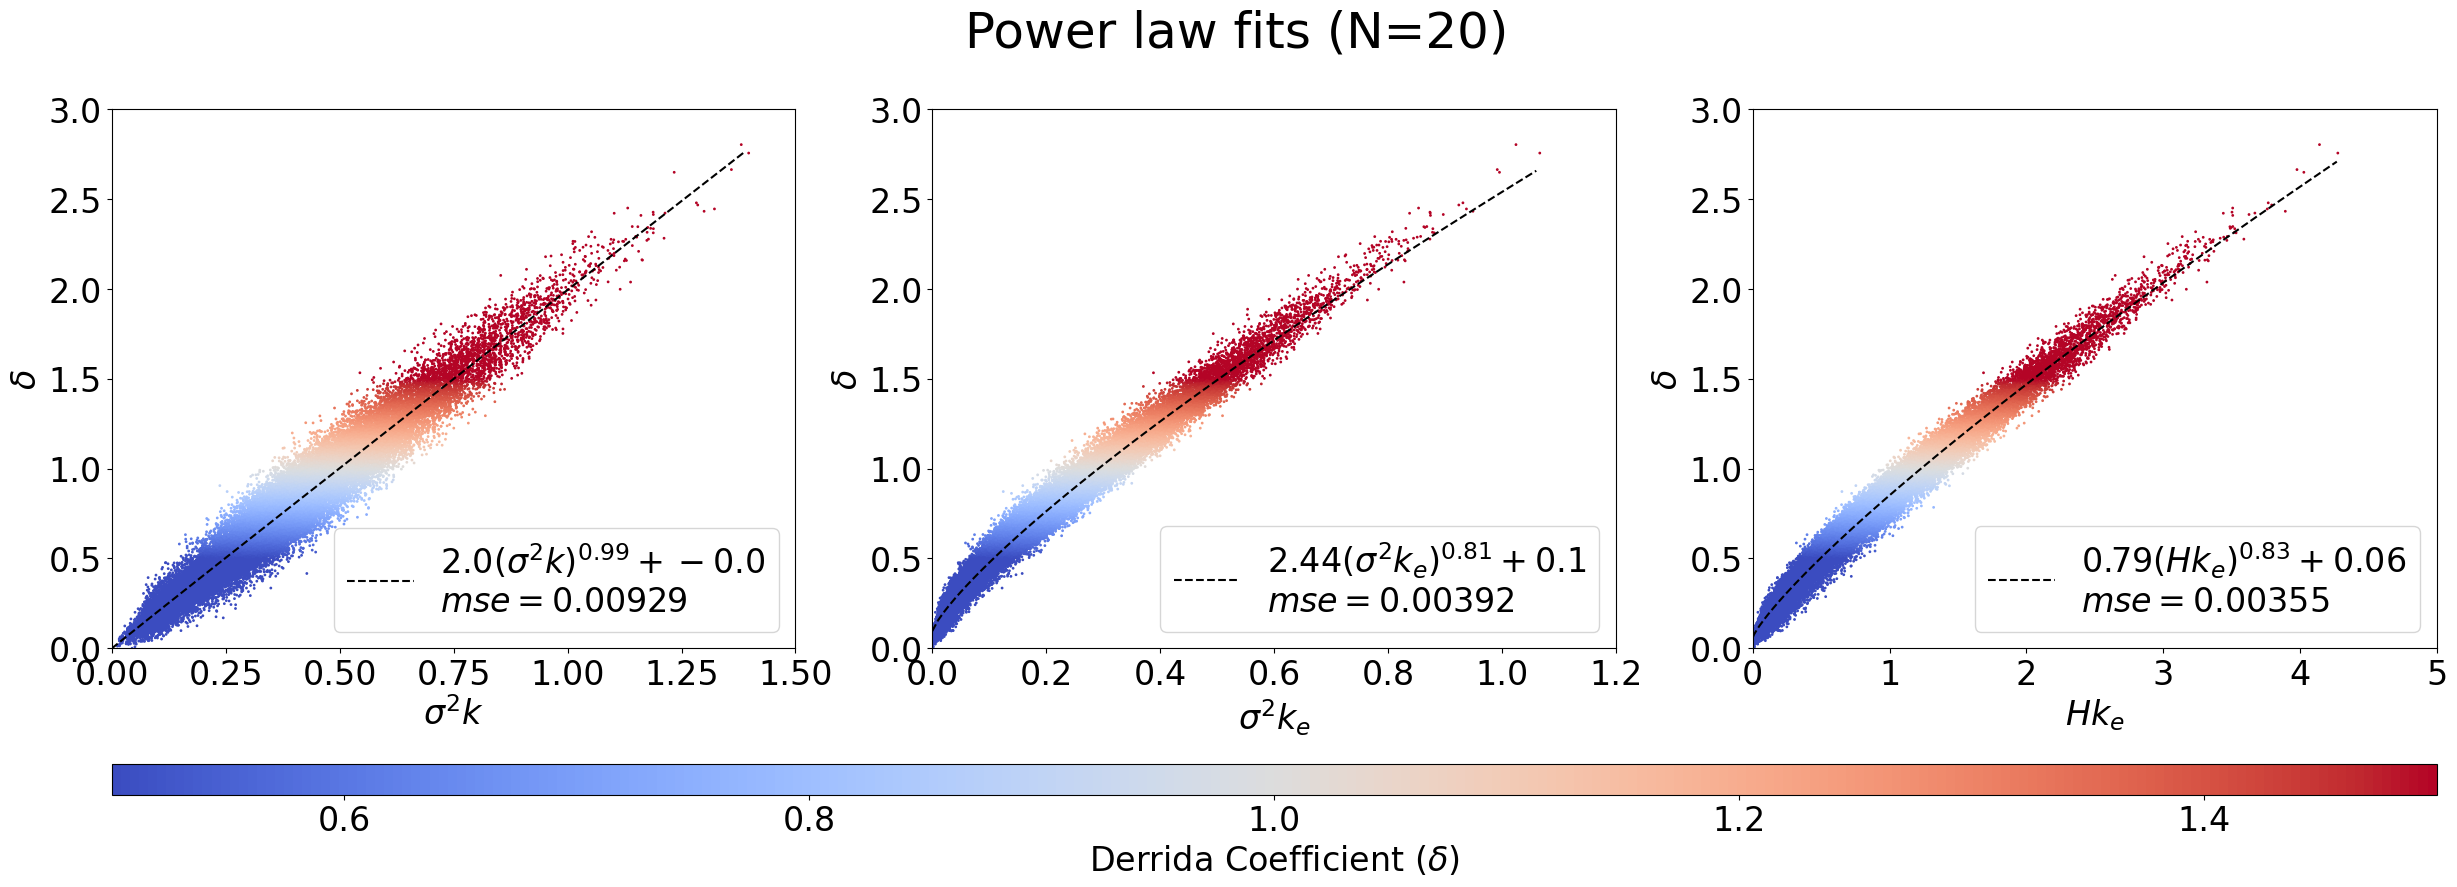

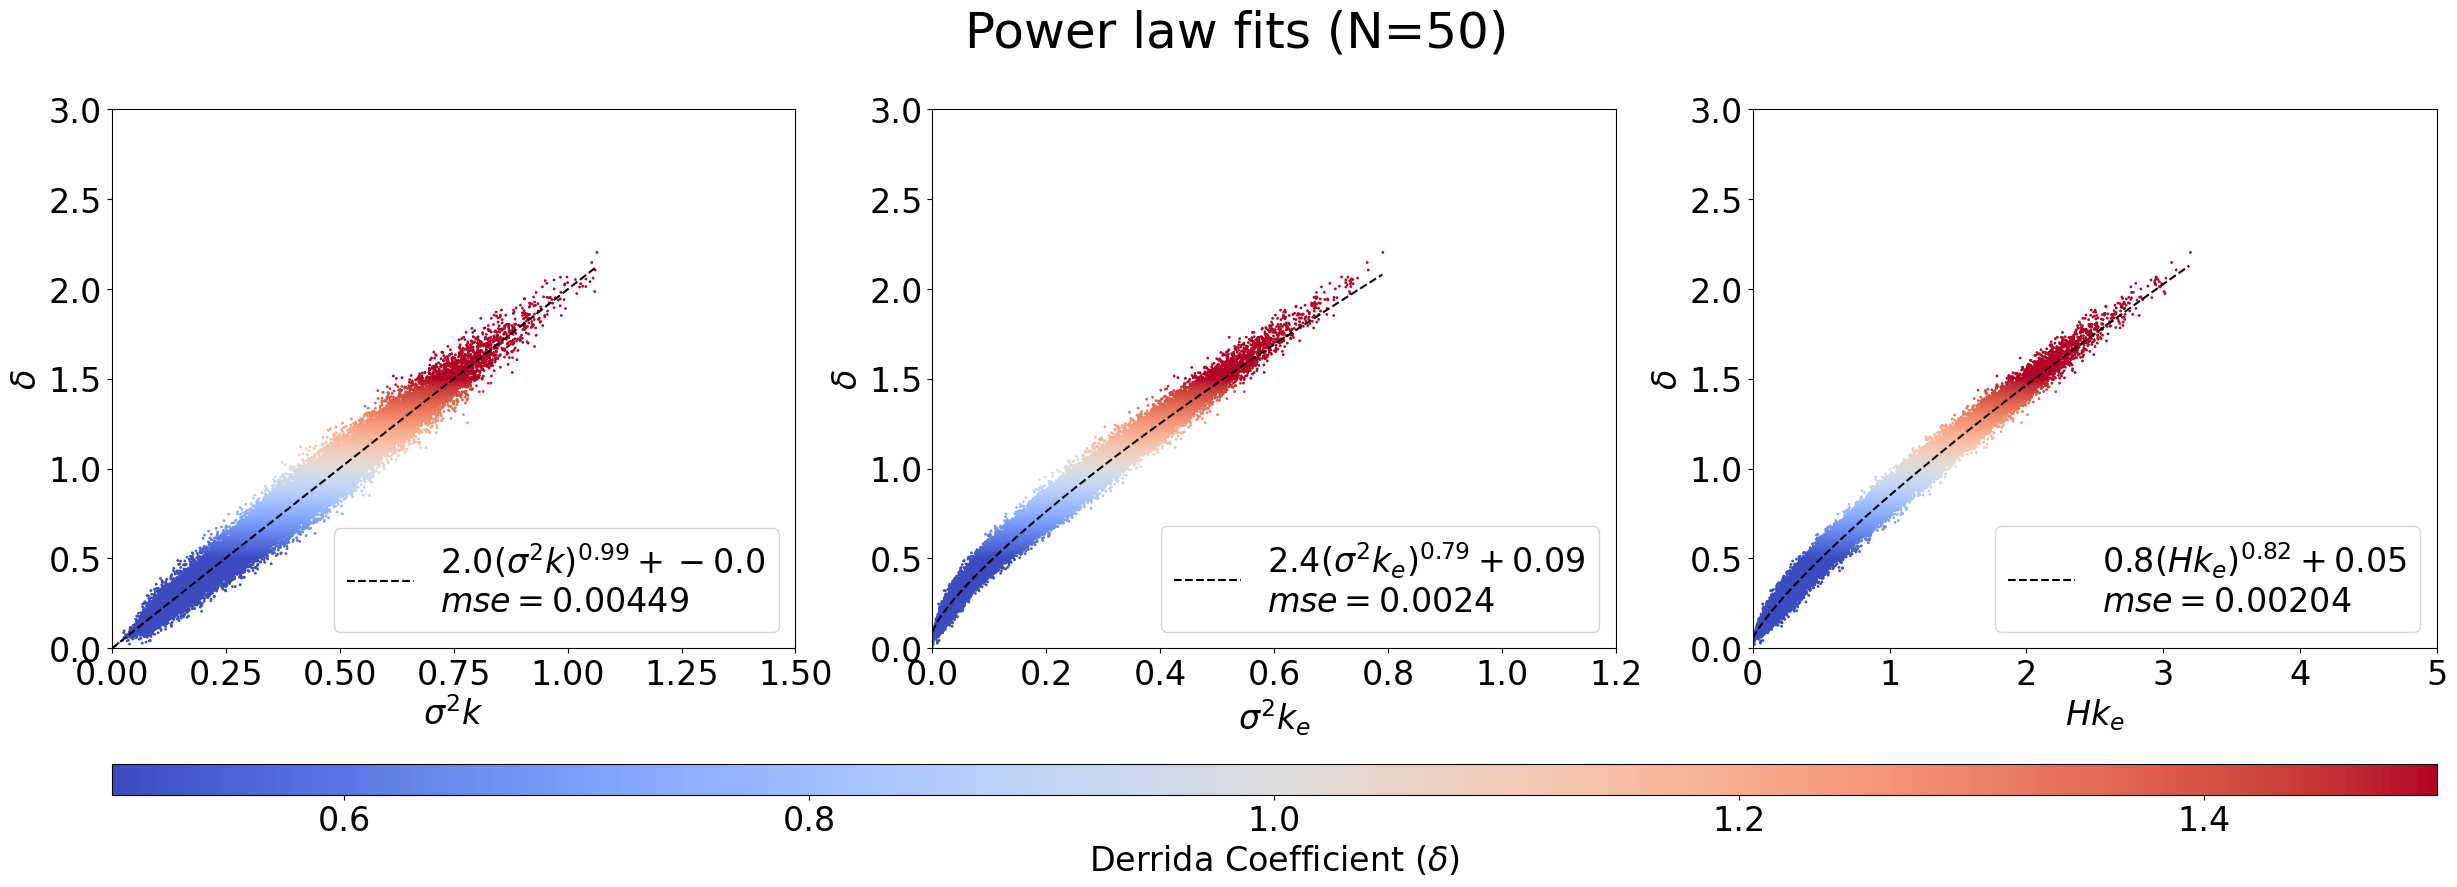

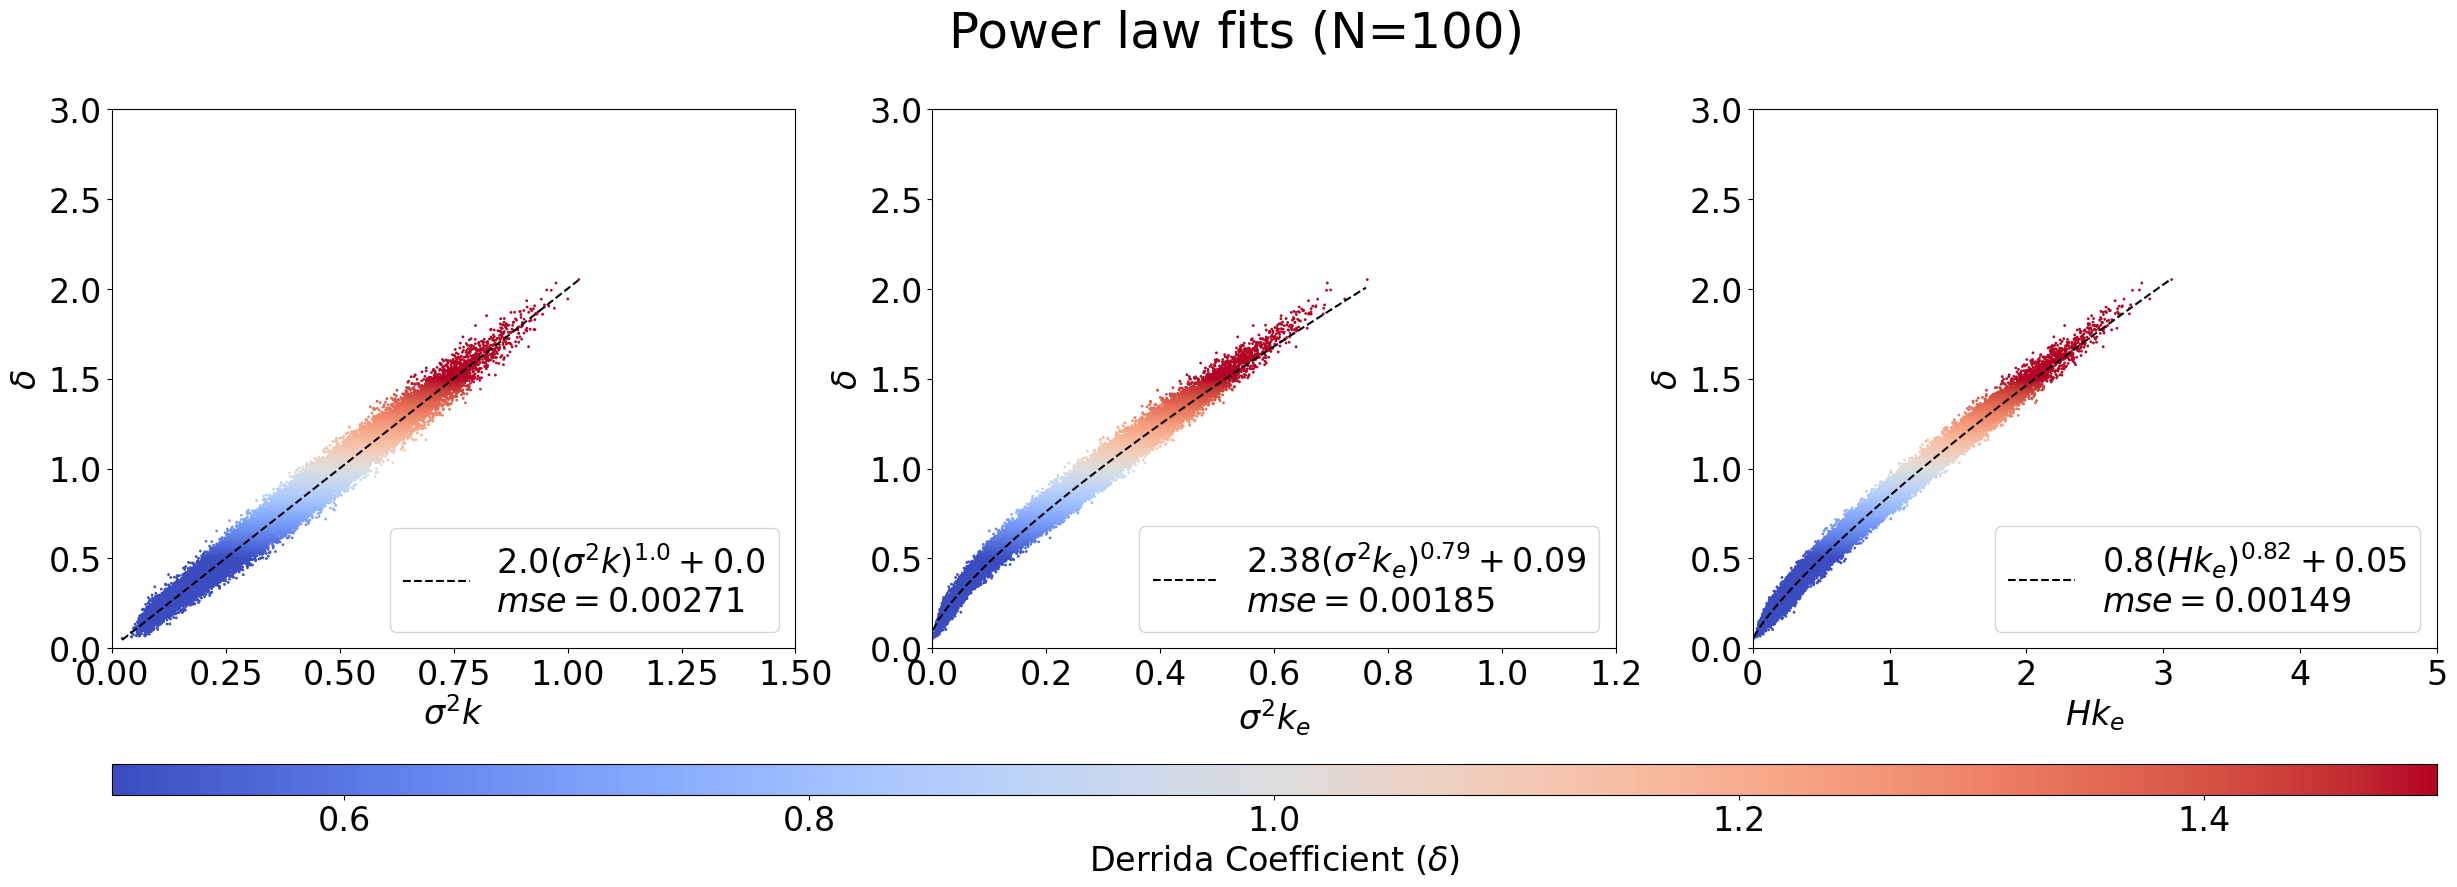

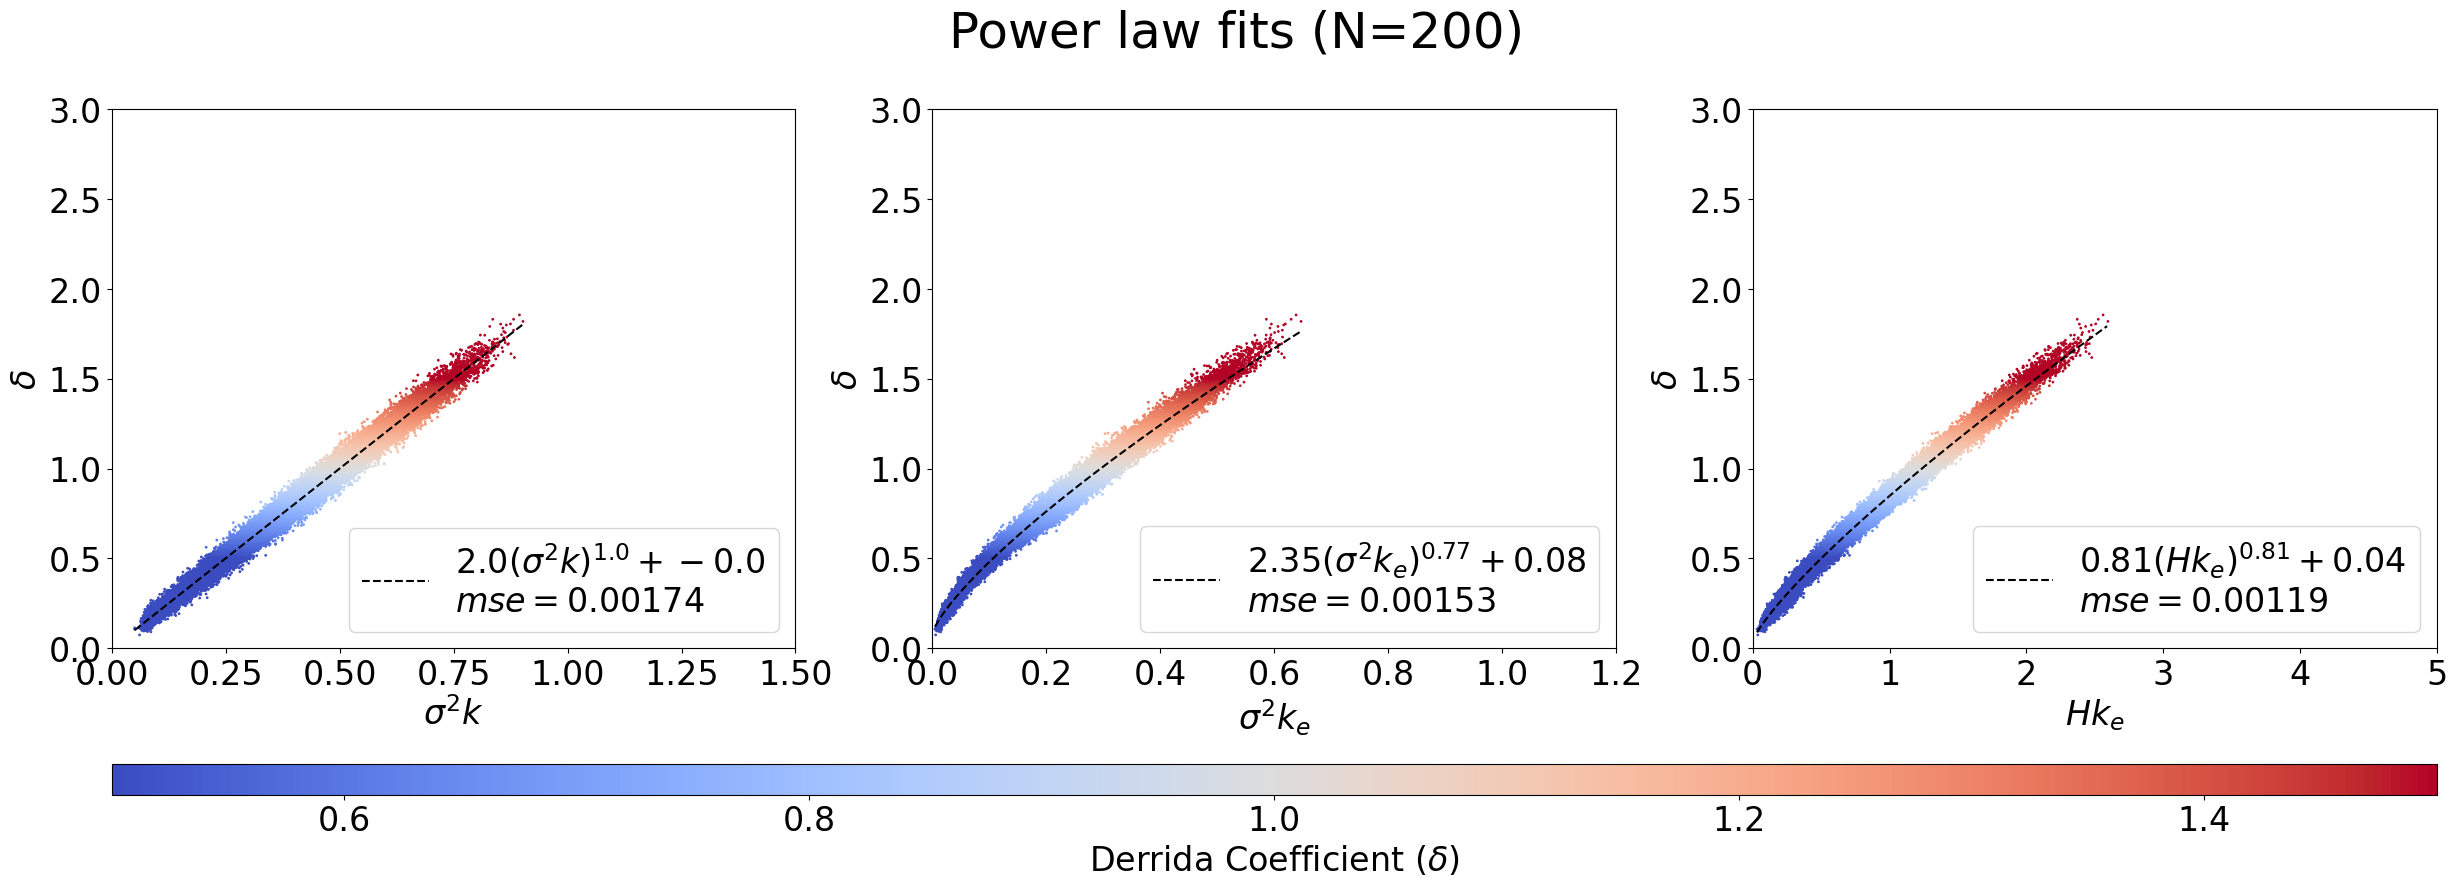

In [7]:
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    
    fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    x=dfN['avgK']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=powerlaw(xfit,c,m,b)
    gof = mse(x,dfN['Derrida'],lambda xi: powerlaw(xi,c,m,b))
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k)^{mstr}+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[0].plot(xfit,yfit,'k--', label=label)
    sc=ax[0].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[0].set_xlabel("$\sigma^2 k$",fontsize=fs)
    ax[0].set_ylabel("$\delta$",fontsize=fs)
    ax[0].tick_params(axis='both', which='major', labelsize=fs)
    ax[0].legend(fontsize=fs, loc = 'lower right')
    ax[0].set_ylim(0,3)
    ax[0].set_xlim(0,1.5)
    
    x=dfN['avgKe']*dfN['avgV']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=powerlaw(xfit,c,m,b)
    gof = mse(x,dfN['Derrida'],lambda xi: powerlaw(xi,c,m,b))
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k_e)^{mstr}+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[1].plot(xfit,yfit,'k--', label=label)
    sc=ax[1].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))    
    ax[1].set_xlabel("$\sigma^2 k_e$",fontsize=fs)
    ax[1].set_ylabel("$\delta$",fontsize=fs)
    ax[1].tick_params(axis='both', which='major', labelsize=fs)
    ax[1].legend(fontsize=fs, loc = 'lower right')
    ax[1].set_ylim(0,3)
    ax[1].set_xlim(0,1.2)
    
    x=dfN['avgKe']*dfN['avgH']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=powerlaw(xfit,c,m,b)
    gof = mse(x,dfN['Derrida'],lambda xi: powerlaw(xi,c,m,b))
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(Hk_e)^{mstr}+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[2].plot(xfit,yfit,'k--',label=label)
    sc=ax[2].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[2].set_xlabel("$Hk_e$",fontsize=fs)
    ax[2].set_ylabel("$\delta$",fontsize=fs)
    ax[2].tick_params(axis='both', which='major', labelsize=fs)
    ax[2].legend(fontsize=fs, loc = 'lower right')
    ax[2].set_ylim(0,3)
    ax[2].set_xlim(0,5)
    
    cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
    cbar.ax.tick_params(axis='both',labelsize=fs)
    cbar.set_label('Derrida Coefficient ($\delta$)',fontsize=fs)
    plt.suptitle(f'Power law fits ({N=})',fontsize=fs*1.5)
    plt.savefig(f'figures/PowerLawFits_RBN_{N}.pdf',bbox_inches='tight')
    plt.savefig(f'figures/PowerLawFits_RBN_{N}.png',bbox_inches='tight')
    plt.show()

#### We repeat the procedure using a partial linear fit.

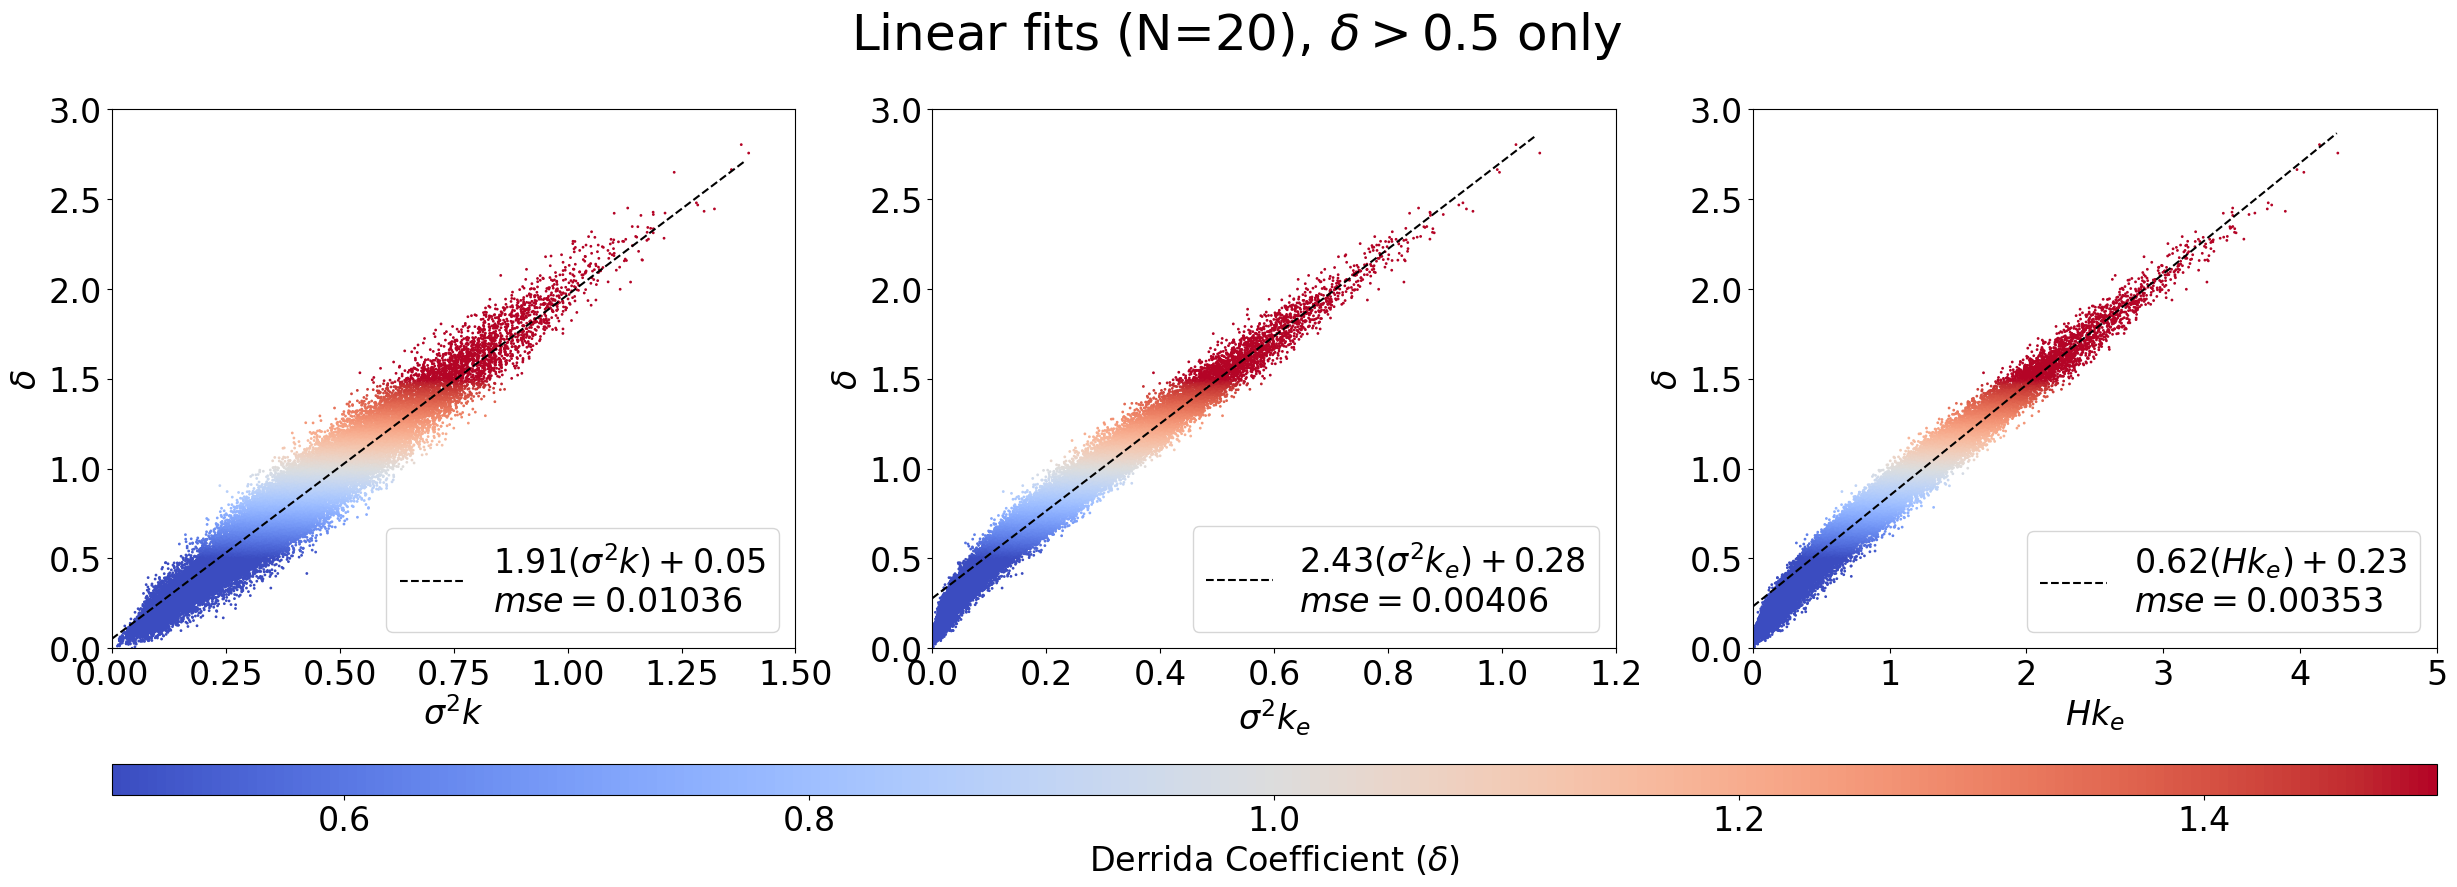

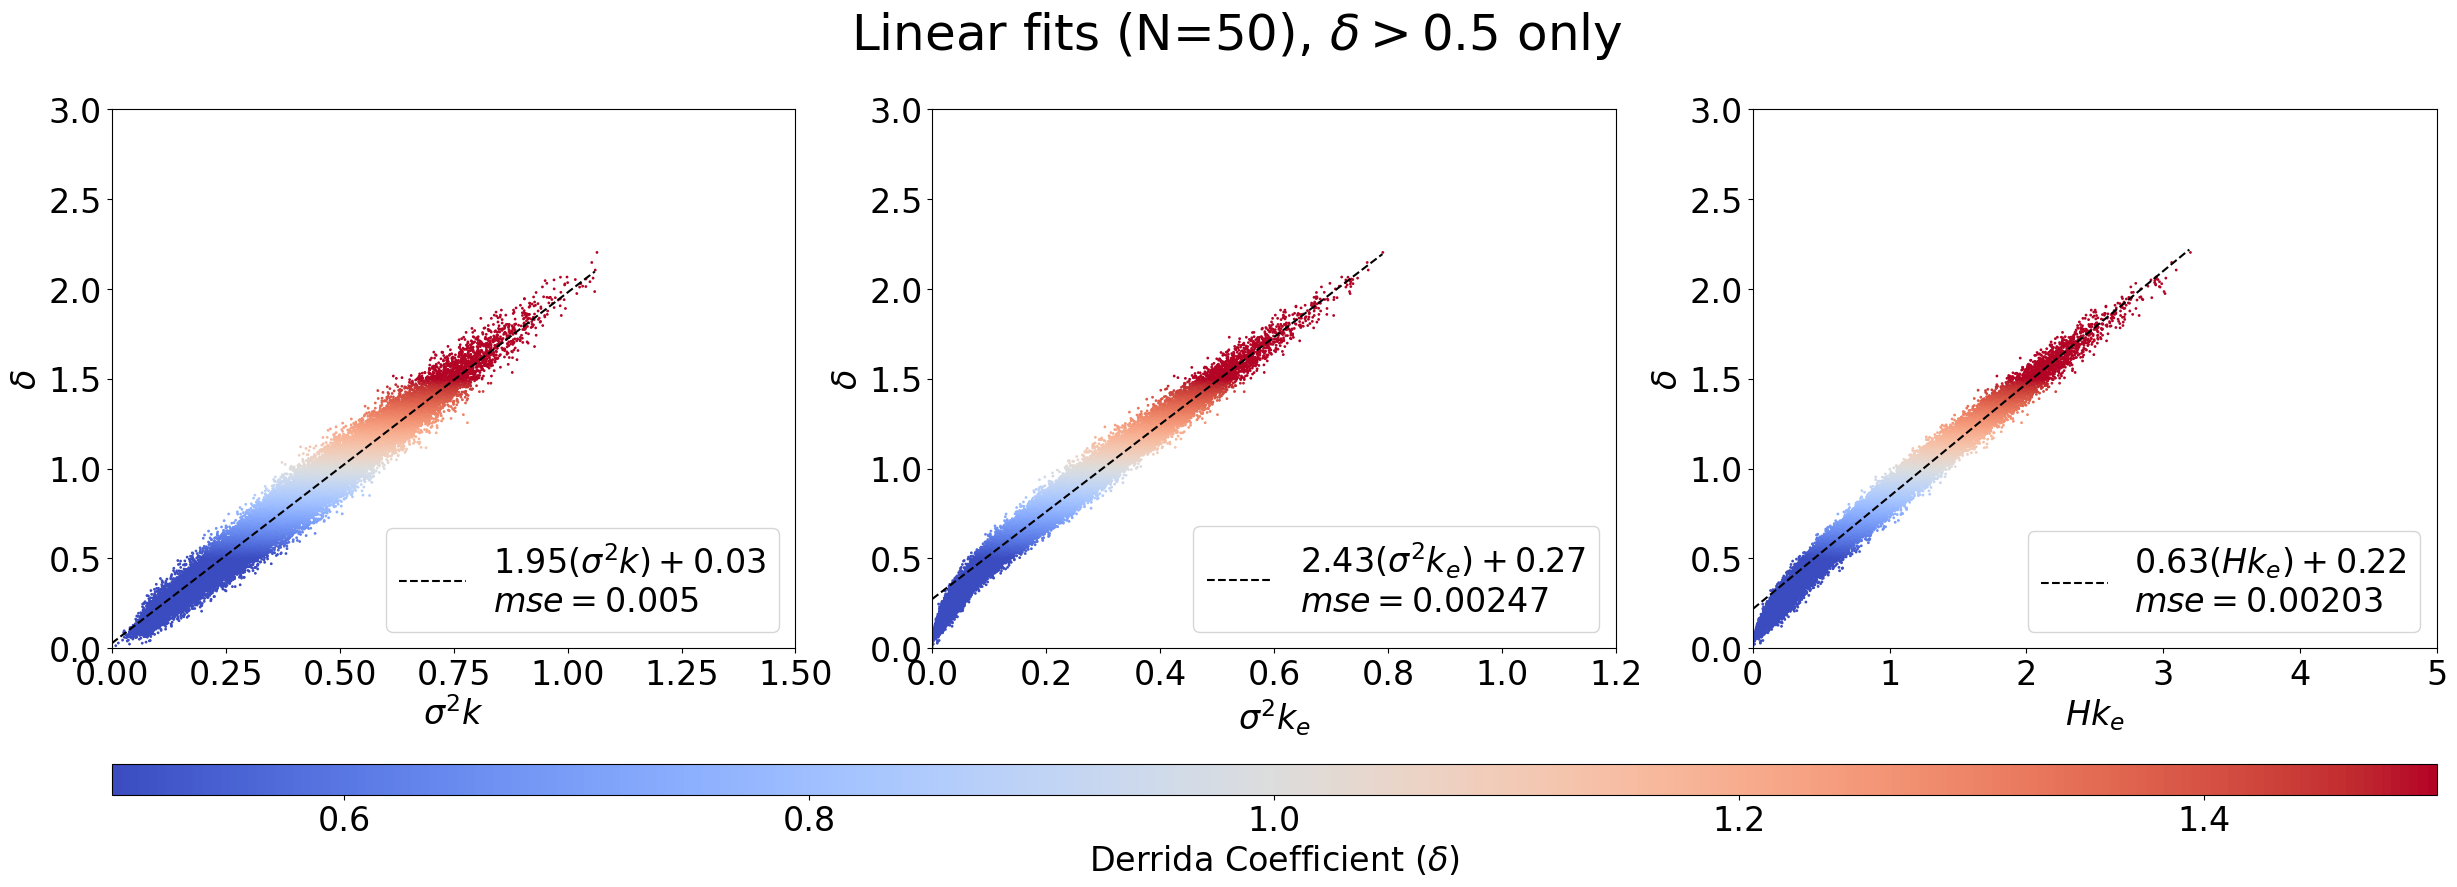

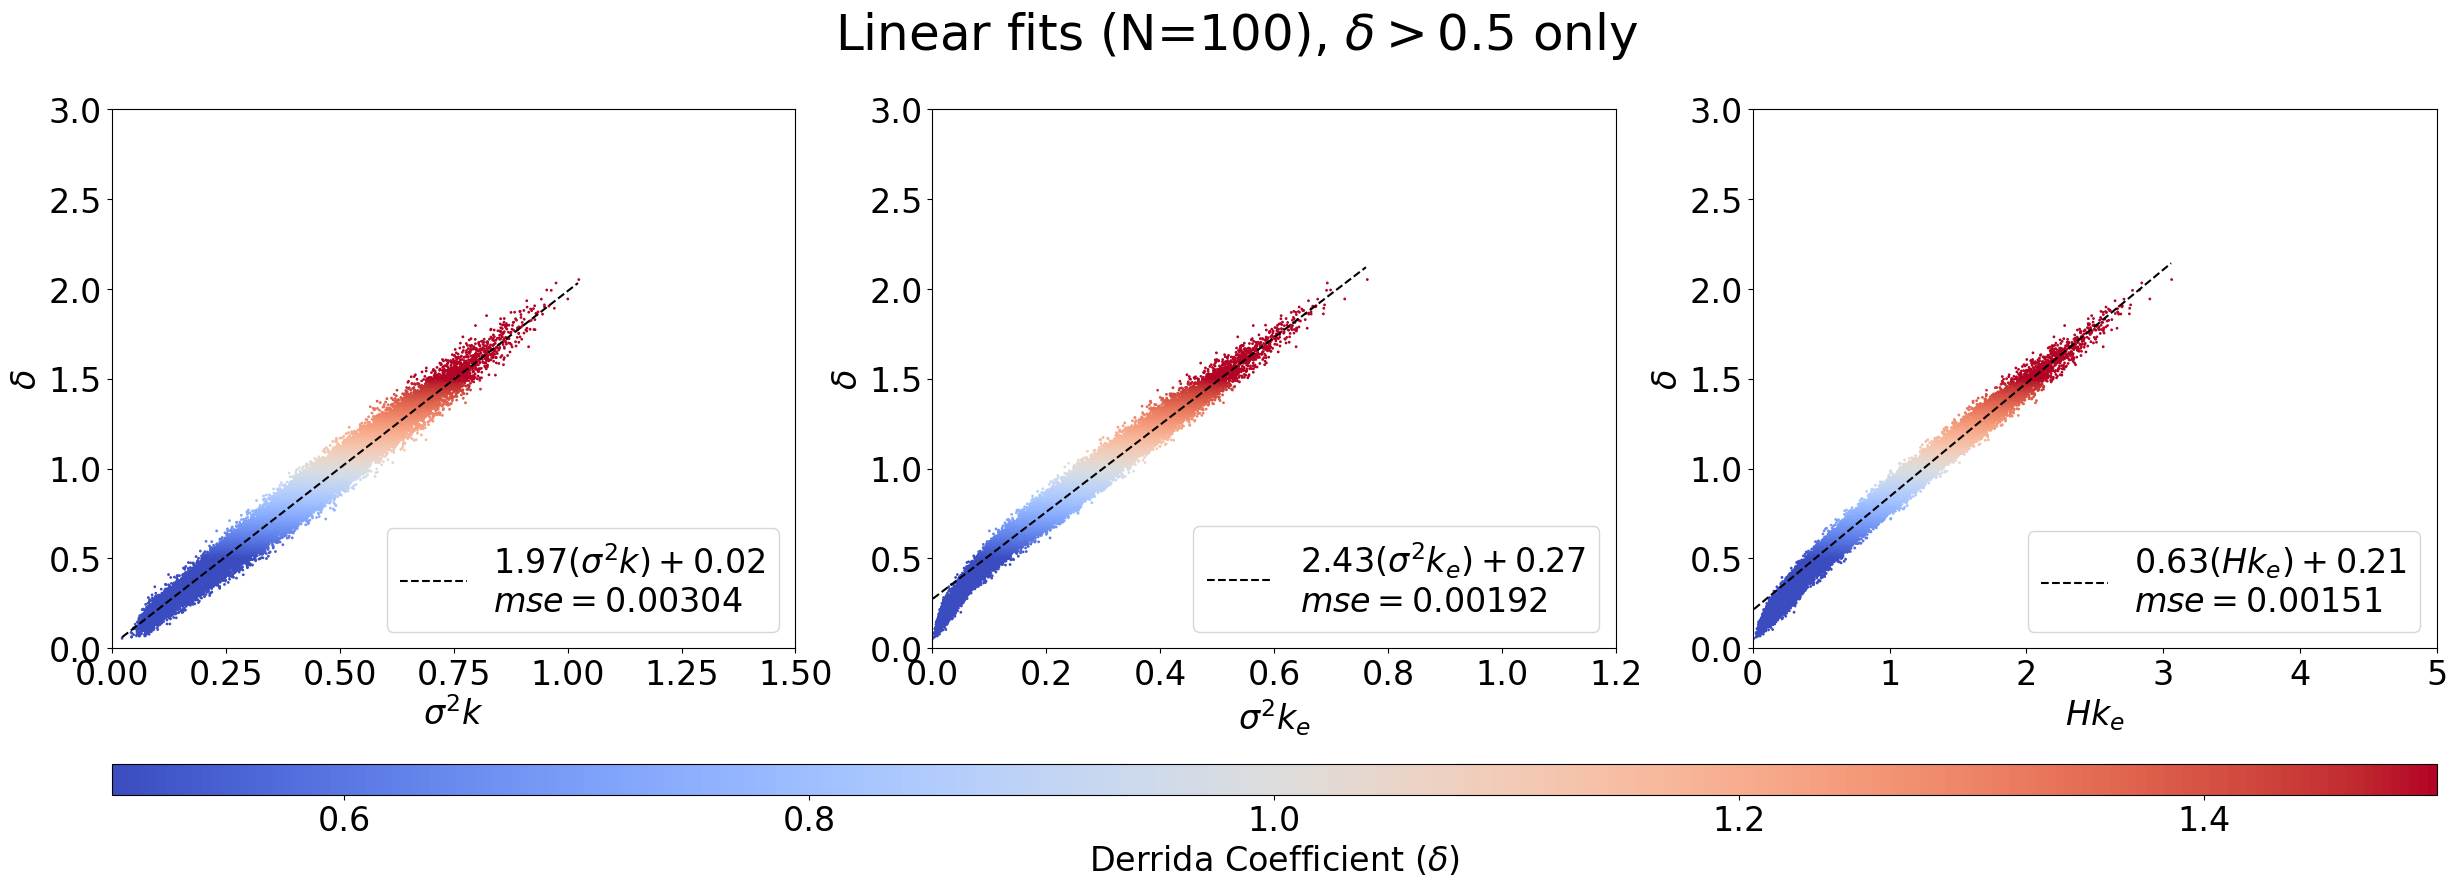

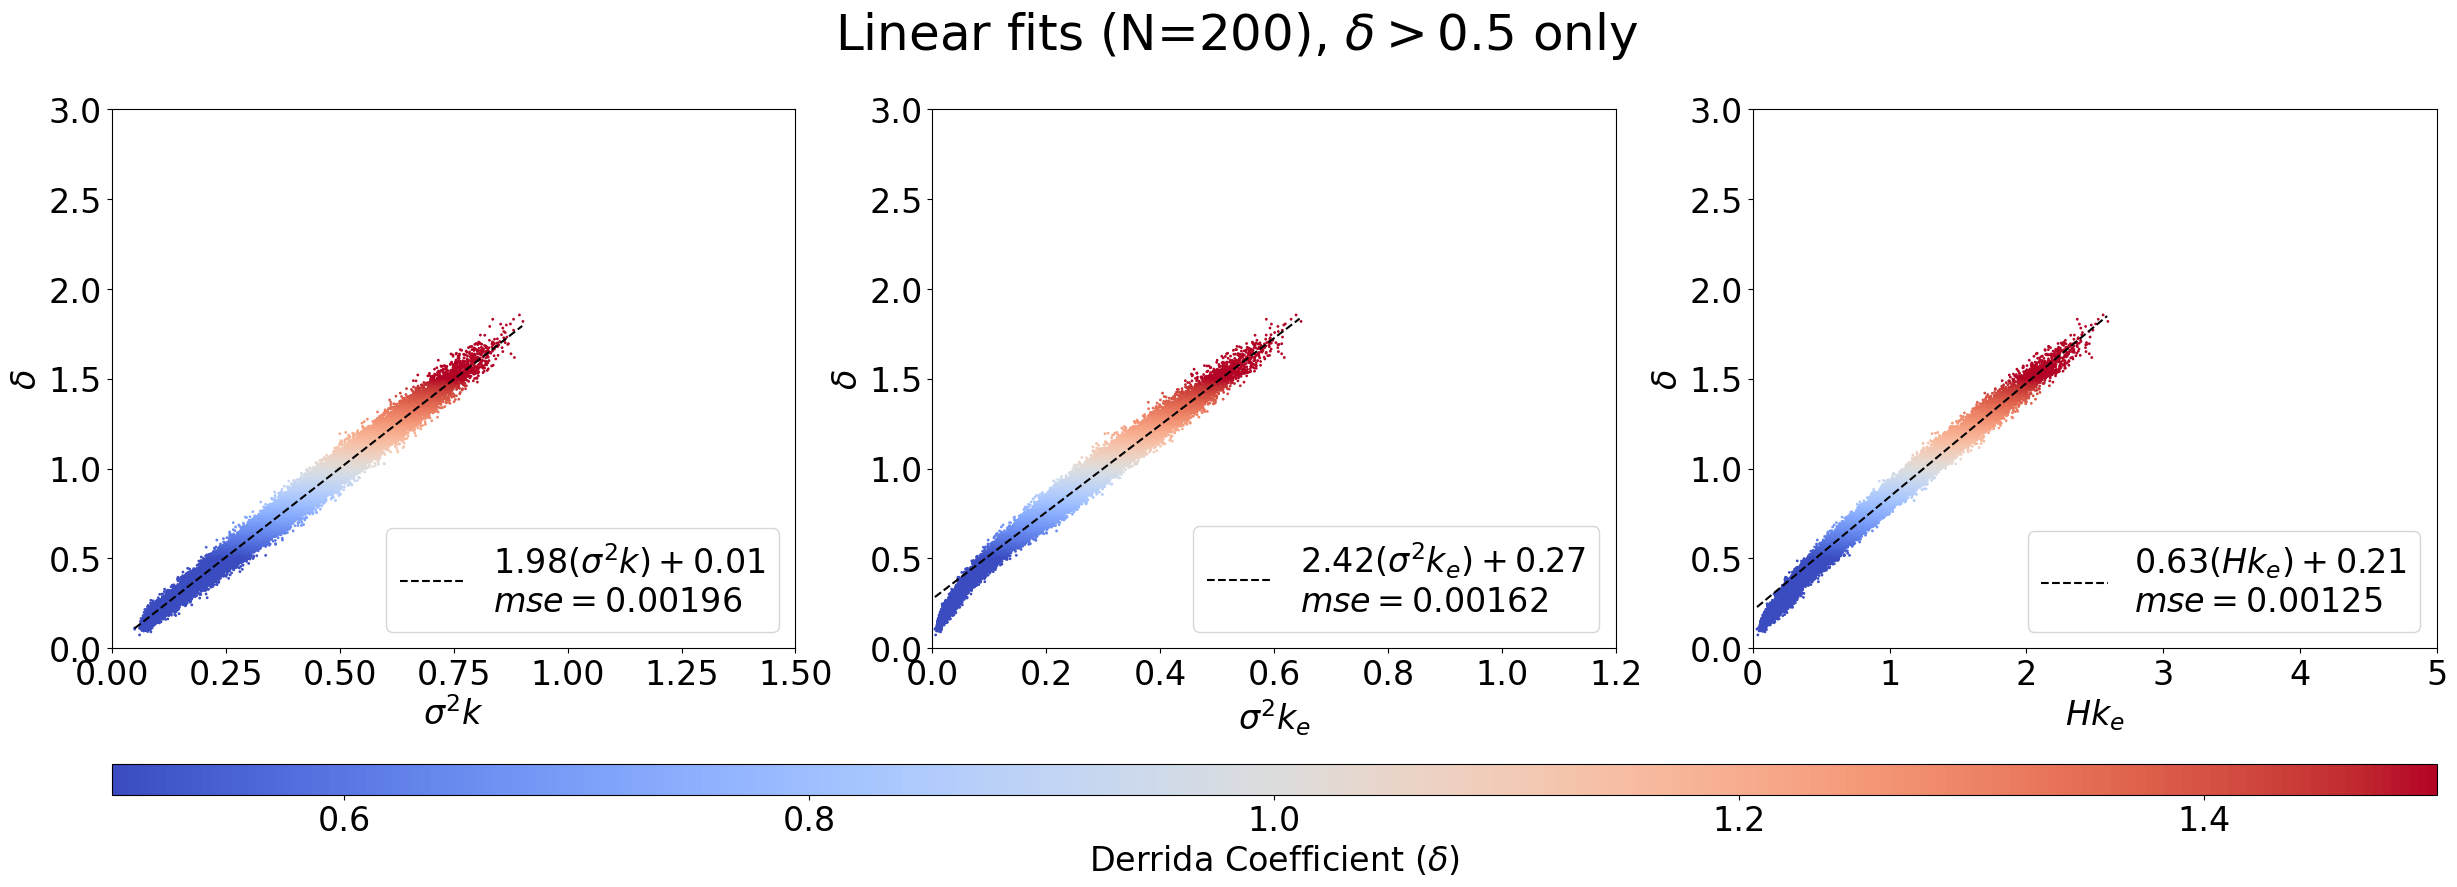

In [8]:
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    
    fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    x=dfN['avgK']*dfN['avgV'] / (dfN['Derrida']>0.5)
    y=dfN['Derrida']
    popt, pcov = curve_fit(linear_law,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    x=dfN['avgK']*dfN['avgV']
    m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=linear_law(xfit,m,b)
    gof = mse(x[dfN['Derrida']>0.5],dfN['Derrida'][dfN['Derrida']>0.5],lambda xi: linear_law(xi,m,b))
    label = f'${np.round(m,2)}(\sigma^2 k)+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[0].plot(xfit,yfit,'k--', label=label)
    sc=ax[0].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[0].set_xlabel("$\sigma^2 k$",fontsize=fs)
    ax[0].set_ylabel("$\delta$",fontsize=fs)
    ax[0].tick_params(axis='both', which='major', labelsize=fs)
    ax[0].legend(fontsize=fs, loc = 'lower right')
    ax[0].set_ylim(0,3)
    ax[0].set_xlim(0,1.5)
    
    x=dfN['avgKe']*dfN['avgV'] / (dfN['Derrida']>0.5)
    popt, pcov = curve_fit(linear_law,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    x=dfN['avgKe']*dfN['avgV']
    m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=linear_law(xfit,m,b)
    gof = mse(x[dfN['Derrida']>0.5],dfN['Derrida'][dfN['Derrida']>0.5],lambda xi: linear_law(xi,m,b))
    label = f'${np.round(m,2)}(\sigma^2 k_e)+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[1].plot(xfit,yfit,'k--', label=label)
    sc=ax[1].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))    
    ax[1].set_xlabel("$\sigma^2 k_e$",fontsize=fs)
    ax[1].set_ylabel("$\delta$",fontsize=fs)
    ax[1].tick_params(axis='both', which='major', labelsize=fs)
    ax[1].legend(fontsize=fs, loc = 'lower right')
    ax[1].set_ylim(0,3)
    ax[1].set_xlim(0,1.2)
    
    x=dfN['avgKe']*dfN['avgH']
    x=dfN['avgKe']*dfN['avgH'] / (dfN['Derrida']>0.5)
    popt, pcov = curve_fit(linear_law,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    x=dfN['avgKe']*dfN['avgH']
    m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    yfit=linear_law(xfit,m,b)
    gof = mse(x[dfN['Derrida']>0.5],dfN['Derrida'][dfN['Derrida']>0.5],lambda xi: linear_law(xi,m,b))
    label = f'${np.round(m,2)}(Hk_e)+{np.round(b,2)}$\n$mse={np.round(gof,5)}$'
    ax[2].plot(xfit,yfit,'k--',label=label)
    sc=ax[2].scatter(x, y, s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[2].set_xlabel("$Hk_e$",fontsize=fs)
    ax[2].set_ylabel("$\delta$",fontsize=fs)
    ax[2].tick_params(axis='both', which='major', labelsize=fs)
    ax[2].legend(fontsize=fs, loc = 'lower right')
    ax[2].set_ylim(0,3)
    ax[2].set_xlim(0,5)
    
    cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
    cbar.ax.tick_params(axis='both',labelsize=fs)
    cbar.set_label('Derrida Coefficient ($\delta$)',fontsize=fs)
    plt.suptitle(f'Linear fits ({N=}), $\delta > 0.5$ only',fontsize=fs*1.5)
    plt.savefig(f'figures/LinearFits_RBN_{N}.pdf',bbox_inches='tight')
    plt.savefig(f'figures/LinearFits_RBN_{N}.png',bbox_inches='tight')
    plt.show()

#### We show the power law fits in the connectivity/bias-spread planes.

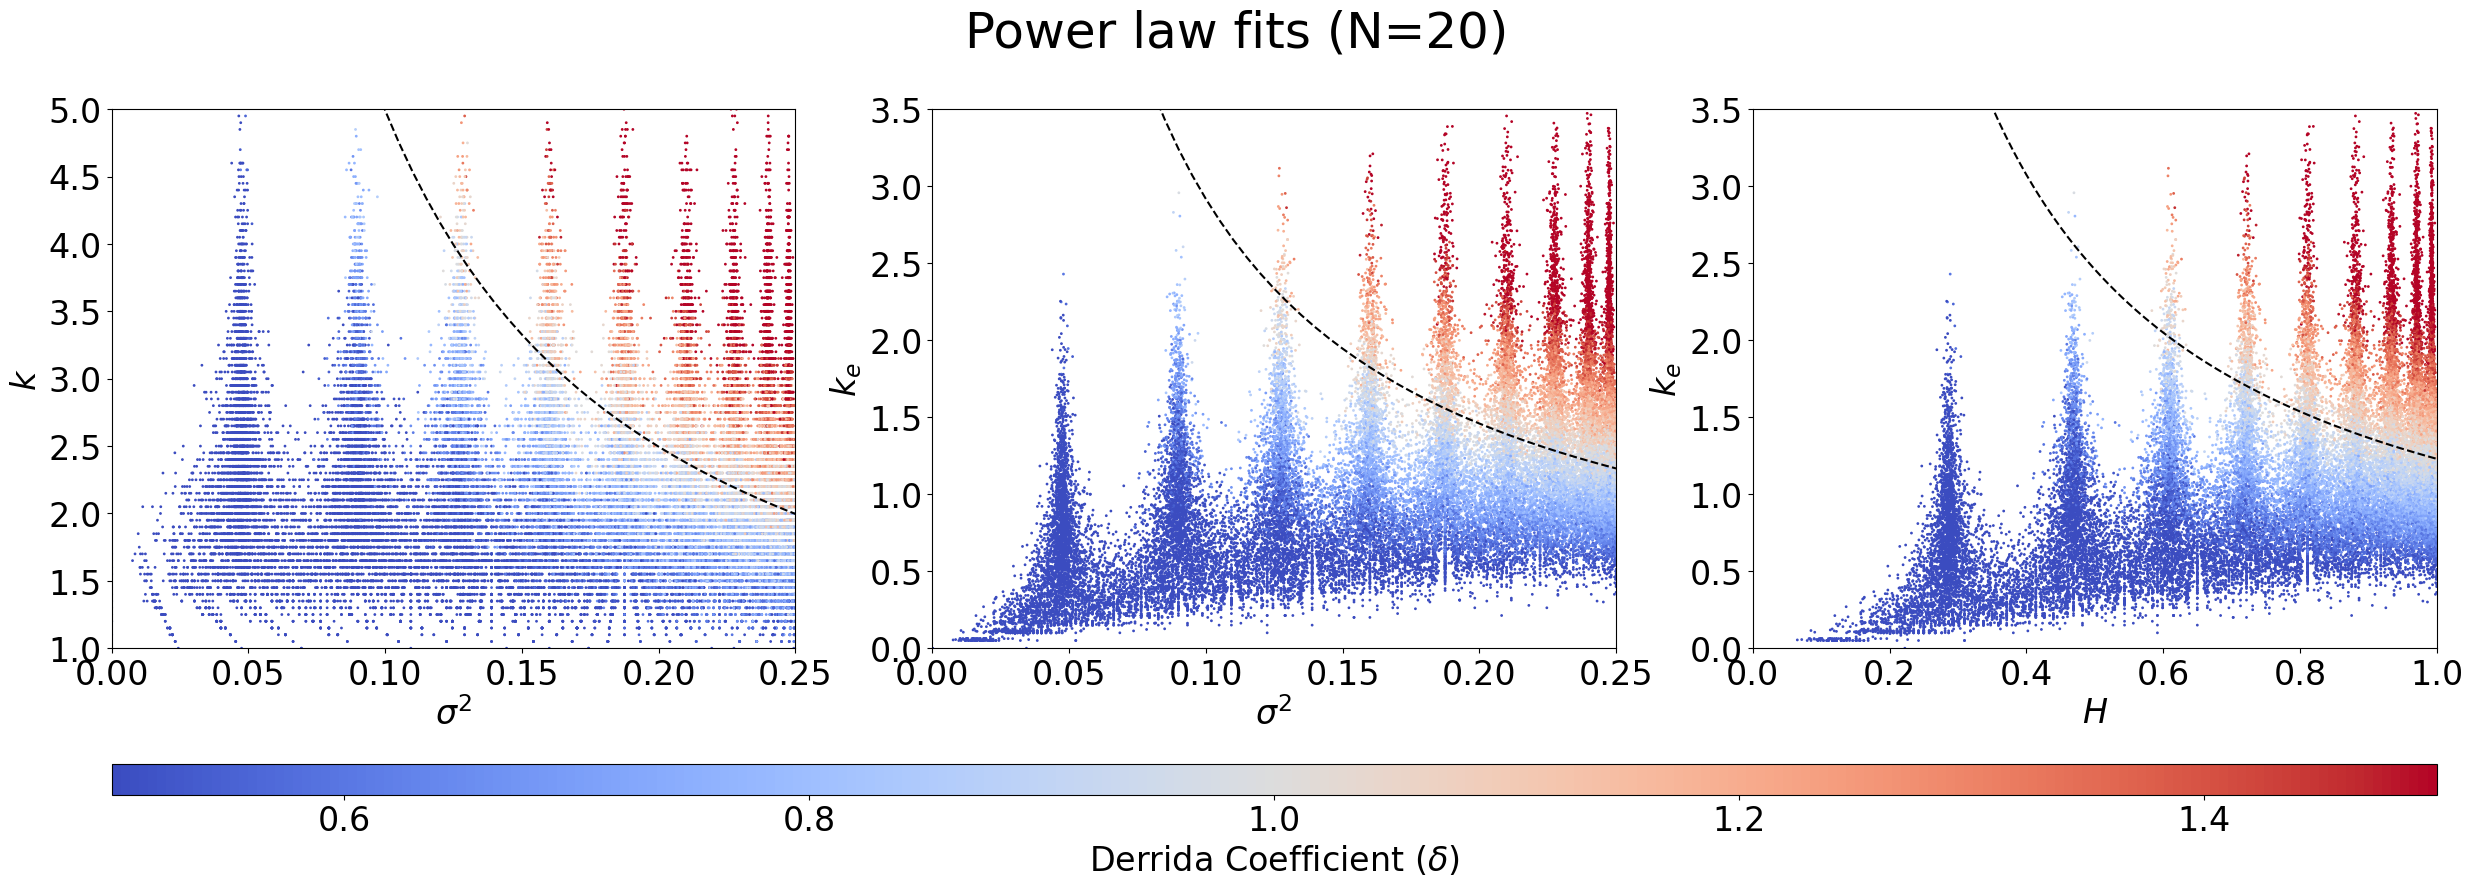

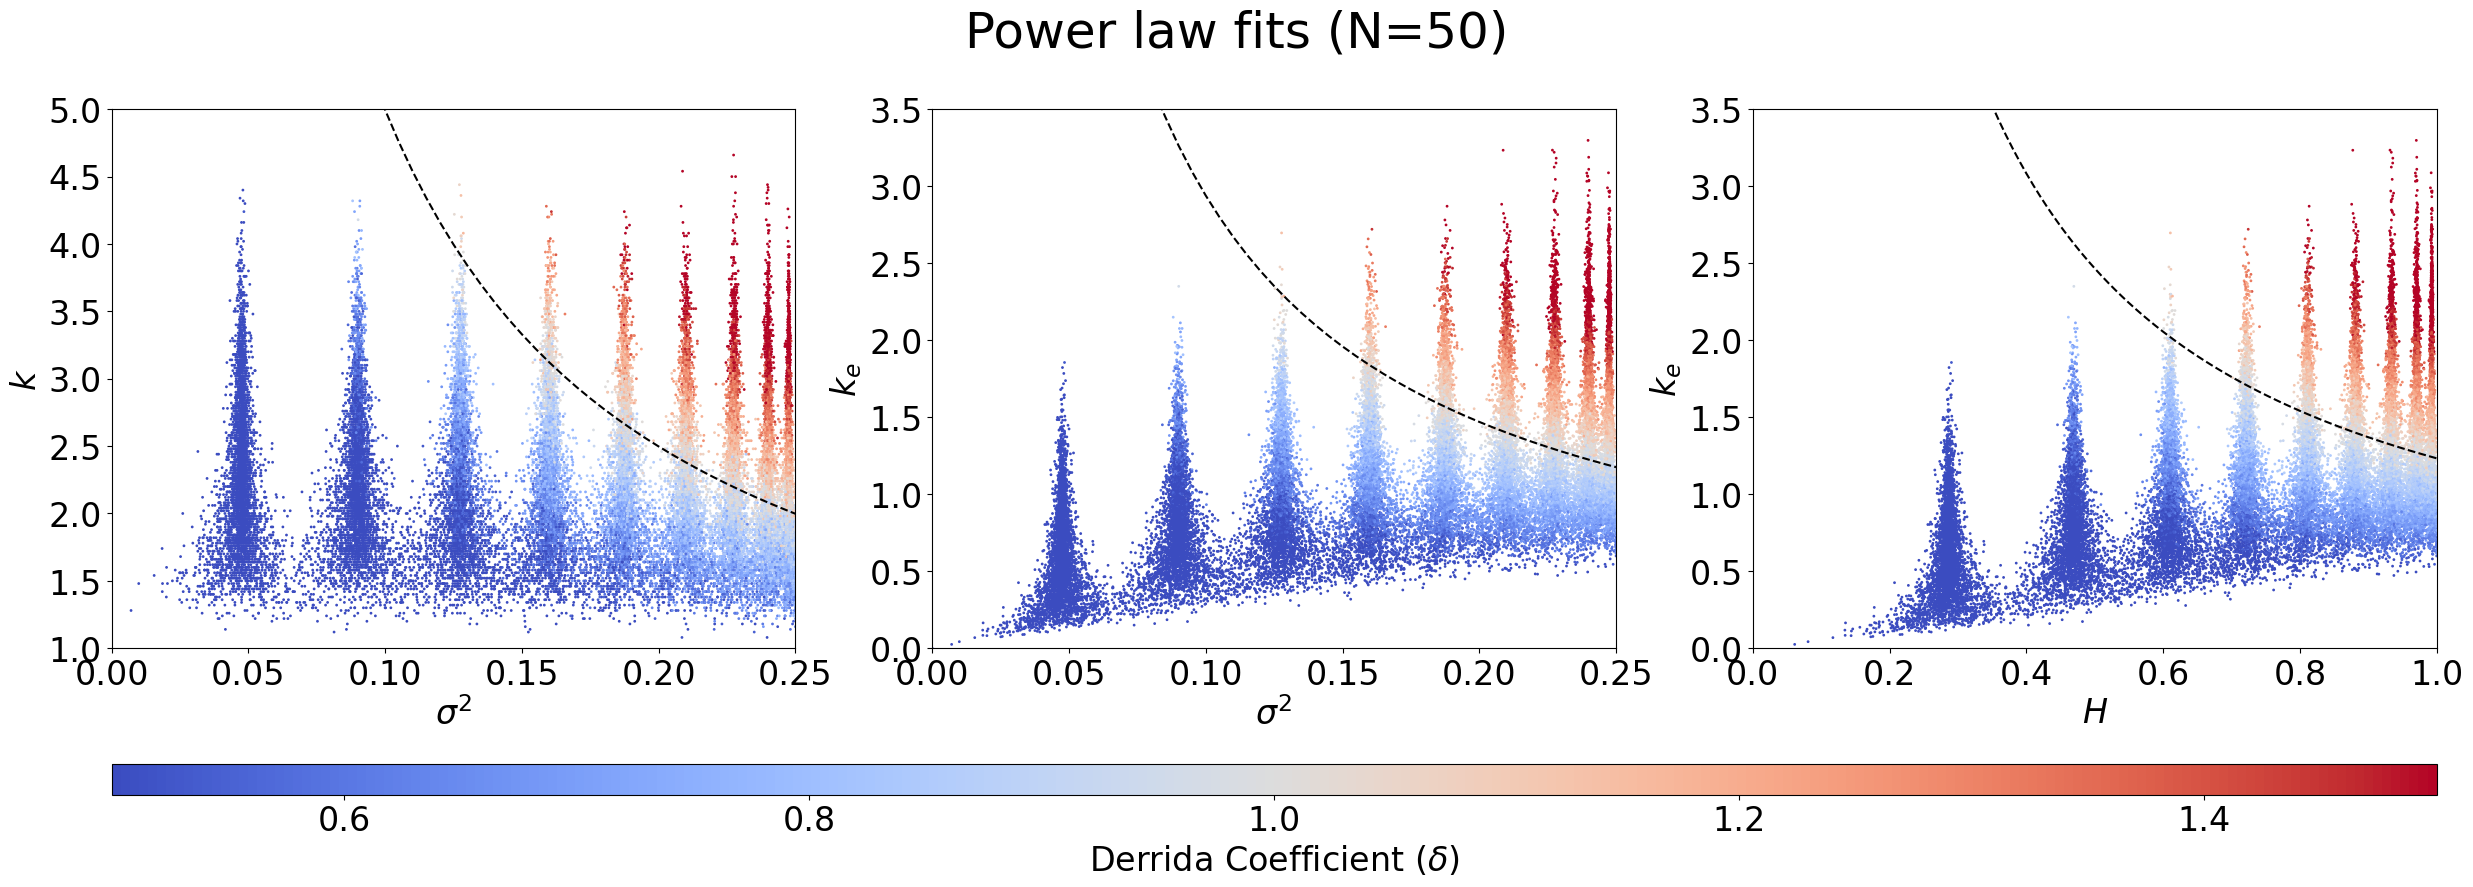

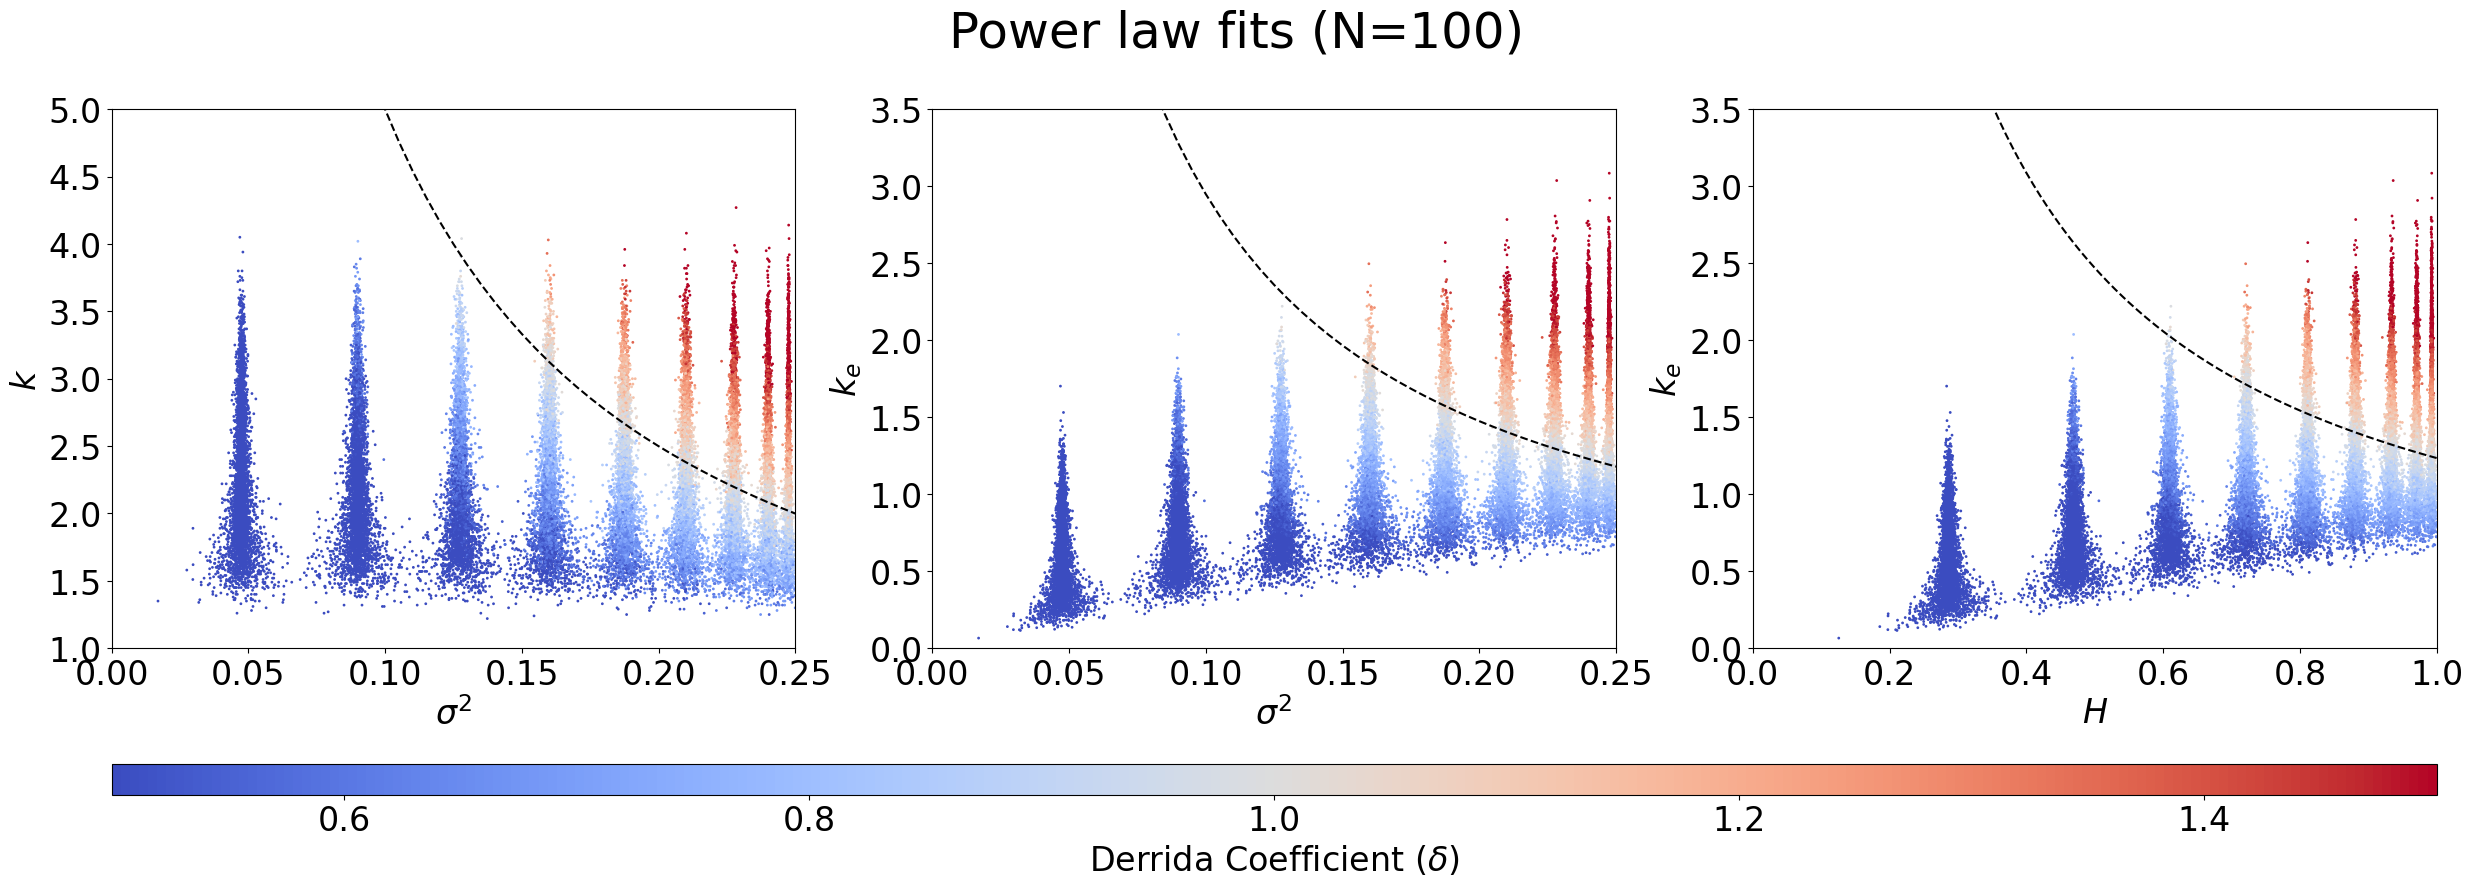

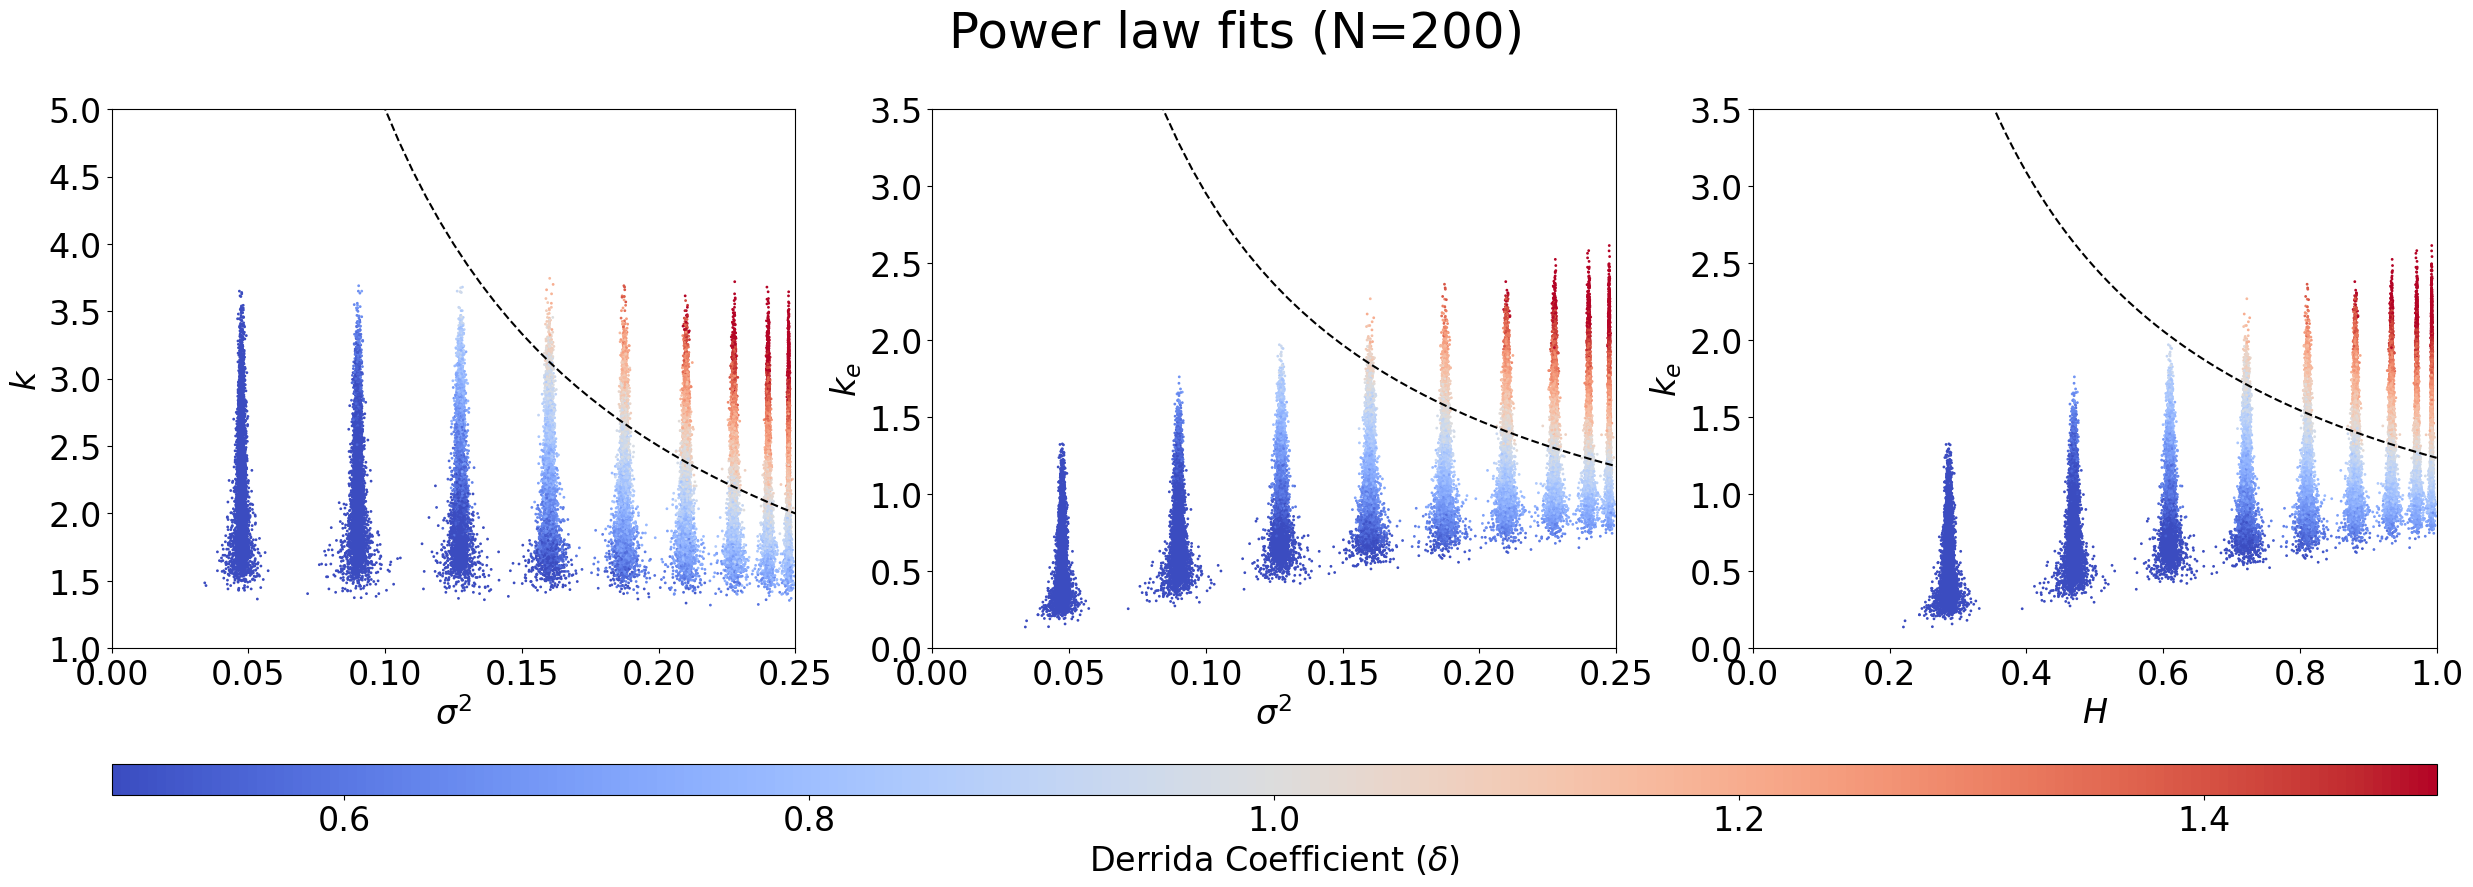

In [9]:
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    
    fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    x=dfN['avgK']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(0.005,0.255,0.005)
    yfit=critical_kappa(xfit,c,m,b)
    label = 'estimated critical boundary'
    ax[0].plot(xfit,yfit,'k--', label=label)
    sc=ax[0].scatter(dfN['avgV'], dfN['avgK'], s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[0].set_xlabel("$\sigma^2$",fontsize=fs)
    ax[0].set_ylabel("$k$",fontsize=fs)
    ax[0].tick_params(axis='both', which='major', labelsize=fs)
    #ax[0].legend(fontsize=fs, loc = 'lower right')
    ax[0].set_xlim(0,0.25)
    ax[0].set_ylim(1,5)
    
    
    x=dfN['avgKe']*dfN['avgV']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(0.01,0.255,0.005)
    yfit=critical_kappa(xfit,c,m,b)
    label = 'estimated critical boundary'
    ax[1].plot(xfit,yfit,'k--', label=label)
    sc=ax[1].scatter(dfN['avgV'], dfN['avgKe'], s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))    
    ax[1].set_xlabel("$\sigma^2$",fontsize=fs)
    ax[1].set_ylabel("$k_e$",fontsize=fs)
    ax[1].tick_params(axis='both', which='major', labelsize=fs)
    #ax[1].legend(fontsize=fs, loc = 'lower right')
    ax[1].set_ylim(0,3.5)
    ax[1].set_xlim(0,0.25)
    
    x=dfN['avgKe']*dfN['avgH']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    xfit=np.arange(x.min(),x.max(),0.01)
    xfit=np.arange(0.01,1.01,0.01)
    yfit=critical_kappa(xfit,c,m,b)
    label = 'estimated critical boundary'
    ax[2].plot(xfit,yfit,'k--',label=label)
    sc=ax[2].scatter(dfN['avgH'], dfN['avgKe'], s=1,
                     c=dfN['Derrida'], cmap=cmap,
                     norm=CenteredNorm(vcenter=1,halfrange=0.5))
    ax[2].set_xlabel("$H$",fontsize=fs)
    ax[2].set_ylabel("$k_e$",fontsize=fs)
    ax[2].tick_params(axis='both', which='major', labelsize=fs)
    #ax[2].legend(fontsize=fs, loc = 'lower right')
    ax[2].set_ylim(0,3.5)
    ax[2].set_xlim(0,1)
    
    cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
    cbar.ax.tick_params(axis='both',labelsize=fs)
    cbar.set_label('Derrida Coefficient ($\delta$)',fontsize=fs)
    plt.suptitle(f'Power law fits ({N=})',fontsize=fs*1.5)
    plt.savefig(f'figures/PowerLawFitsAlt_RBN_{N}.pdf',bbox_inches='tight')
    plt.savefig(f'figures/PowerLawFitsAlt_RBN_{N}.png',bbox_inches='tight')
    plt.show()

#### We now show how often the fits (and sensitivity) agree with $\delta$ in predicting the dynamical regime.

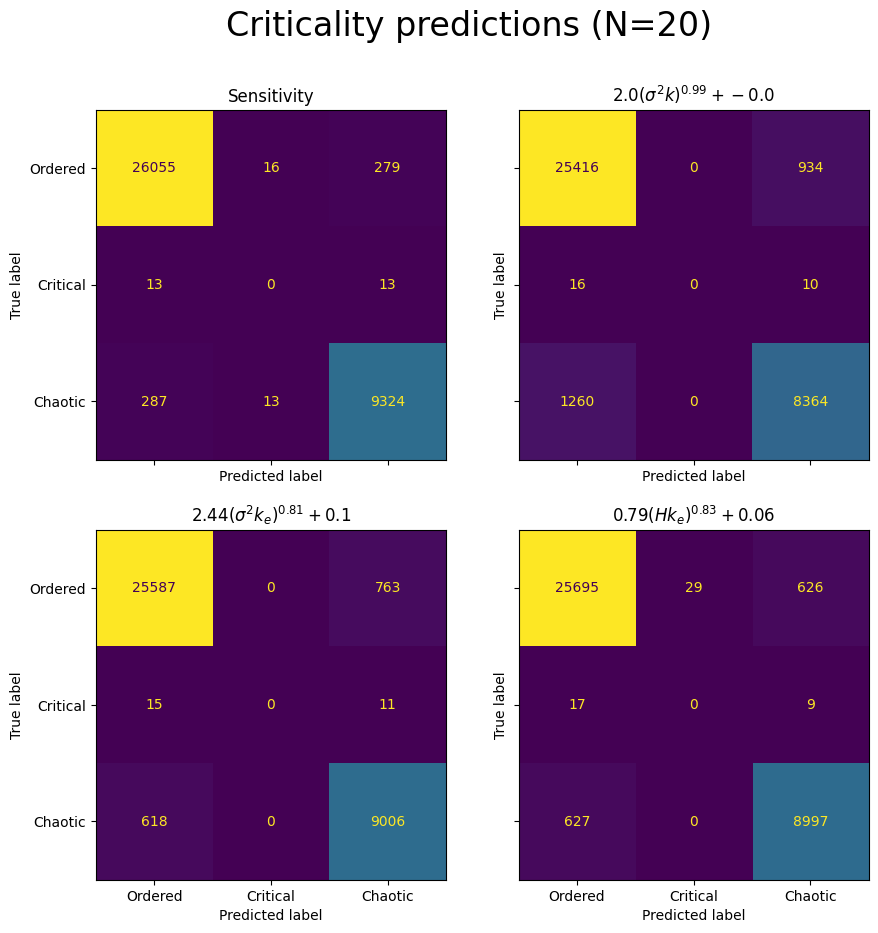

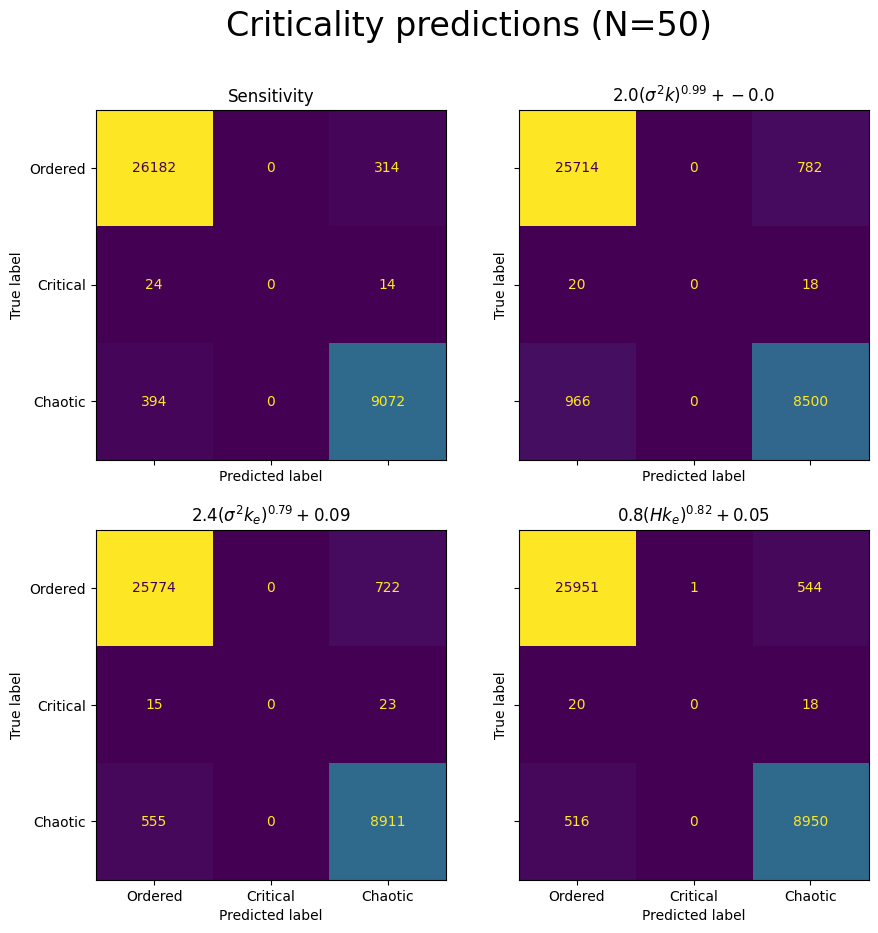

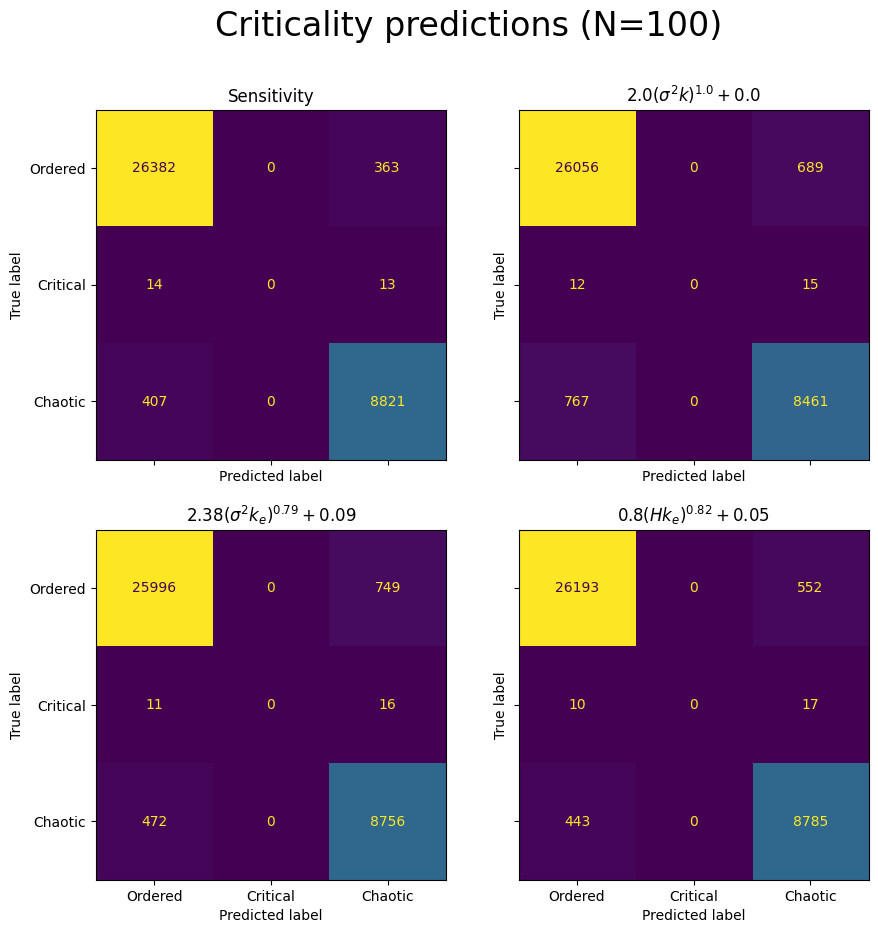

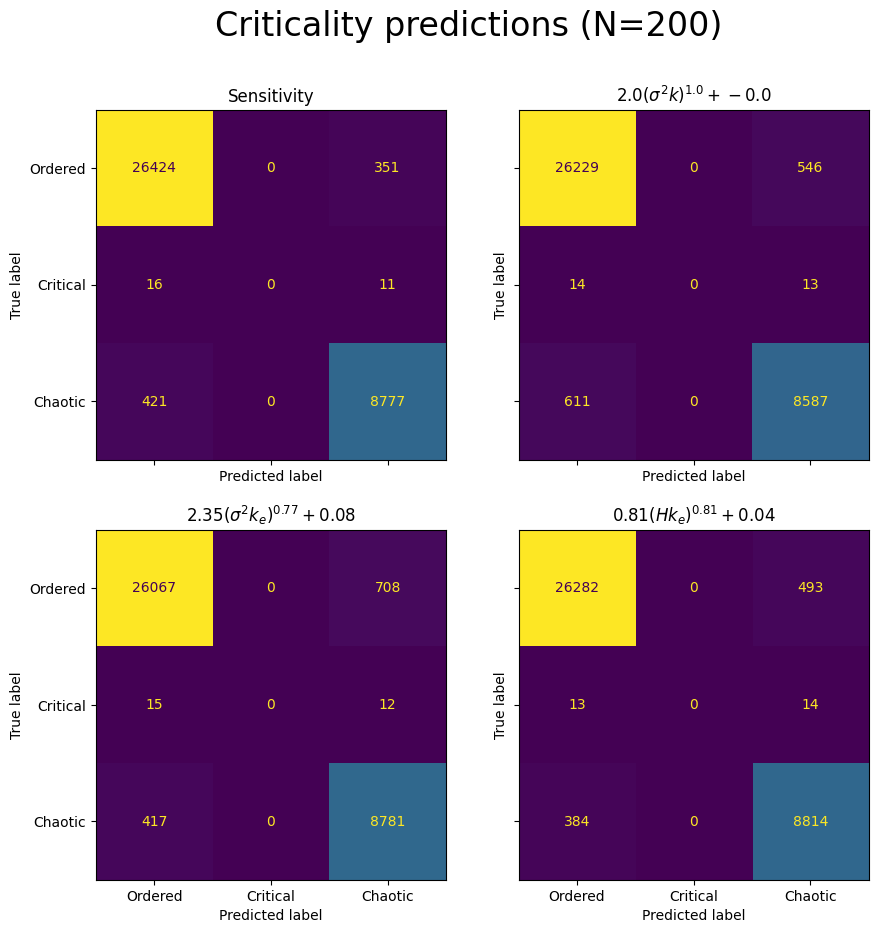

In [10]:
fs = 24
for N in Nvals:
    dfN = dfall[dfall['N']==N]
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey='row', sharex='col', facecolor='white')
    cmap = plt.cm.get_cmap('coolwarm')#.reversed()
    
    x=dfN['avgS']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    yfit=powerlaw(x,1,1,0)
    truth = (y>1).astype(int) - (y<1).astype(int)
    preds = (yfit>1).astype(int)-(yfit<1).astype(int)
    confusion_matrix = metrics.confusion_matrix(truth,preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Ordered', 'Critical', 'Chaotic'])
    cm_display.plot(ax=ax[0,0])
    cm_display.im_.colorbar.remove()
    ax[0,0].set_title('Sensitivity')
    
    x=dfN['avgK']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    yfit=powerlaw(x,c,m,b)
    truth = (y>1).astype(int) - (y<1).astype(int)
    preds = (yfit>1).astype(int)-(yfit<1).astype(int)
    confusion_matrix = metrics.confusion_matrix(truth,preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Ordered', 'Critical', 'Chaotic'])
    cm_display.plot(ax=ax[0,1])
    cm_display.im_.colorbar.remove()
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k)^{mstr}+{np.round(b,2)}$'
    ax[0,1].set_title(label)
    
    x=dfN['avgKe']*dfN['avgV']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    yfit=powerlaw(x,c,m,b)
    truth = (y>1).astype(int) - (y<1).astype(int)
    preds = (yfit>1).astype(int)-(yfit<1).astype(int)
    confusion_matrix = metrics.confusion_matrix(truth,preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Ordered', 'Critical', 'Chaotic'])
    cm_display.plot(ax=ax[1,0])
    cm_display.im_.colorbar.remove()
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(\sigma^2 k_e)^{mstr}+{np.round(b,2)}$'
    ax[1,0].set_title(label)
    
    x=dfN['avgKe']*dfN['avgH']
    y=dfN['Derrida']
    popt, pcov = curve_fit(powerlaw,x[np.isfinite(x)],dfN['Derrida'][np.isfinite(x)])
    c, m, b = popt
    yfit=powerlaw(x,c,m,b)
    truth = (y>1).astype(int) - (y<1).astype(int)
    preds = (yfit>1).astype(int)-(yfit<1).astype(int)
    confusion_matrix = metrics.confusion_matrix(truth,preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Ordered', 'Critical', 'Chaotic'])
    cm_display.plot(ax=ax[1,1])
    cm_display.im_.colorbar.remove()
    mstr='{'+str(np.round(m,2))+'}'
    label = f'${np.round(c,2)}(H k_e)^{mstr}+{np.round(b,2)}$'
    ax[1,1].set_title(label)
    
    fig.suptitle(f'Criticality predictions ({N=})',fontsize=fs)
    plt.savefig(f'figures/PowerLawConfusion_RBN_{N}.pdf',bbox_inches='tight')
    plt.savefig(f'figures/PowerLawConfusion_RBN_{N}.png',bbox_inches='tight')
    plt.show()

#### We now begin analysis of the Cell Collective models.
We begin by importing the data and defining the bias entropy and bias variance.

In [11]:
dfcc = pd.read_csv('cc_network_data.csv')
dfcc['avgH'] = -np.log2(dfcc['bias'])*dfcc['bias'] - np.log2(1-dfcc['bias'])*(1-dfcc['bias'])
dfcc['avgV']=(1-dfcc['bias'])*dfcc['bias']

#### We examine some summary statistics of the Cell Collective networks.

In [12]:
print('average number of nodes:', dfcc['Nnodes'].mean())
print('Derrida coefficient quartiles:', np.percentile(dfcc['dc'], [0, 25, 50, 75, 100]))
print('Derrida coefficient mean and standard deviation:', dfcc['dc'].mean(), ',',  dfcc['dc'].std())

average number of nodes: 46.78378378378378
Derrida coefficient quartiles: [0.739   0.94    0.976   1.02175 1.312  ]
Derrida coefficient mean and standard deviation: 0.9701486486486486 , 0.0910457784044495


#### We highlight that sensitivity and the Derrida coefficient are in good agreement in these models.

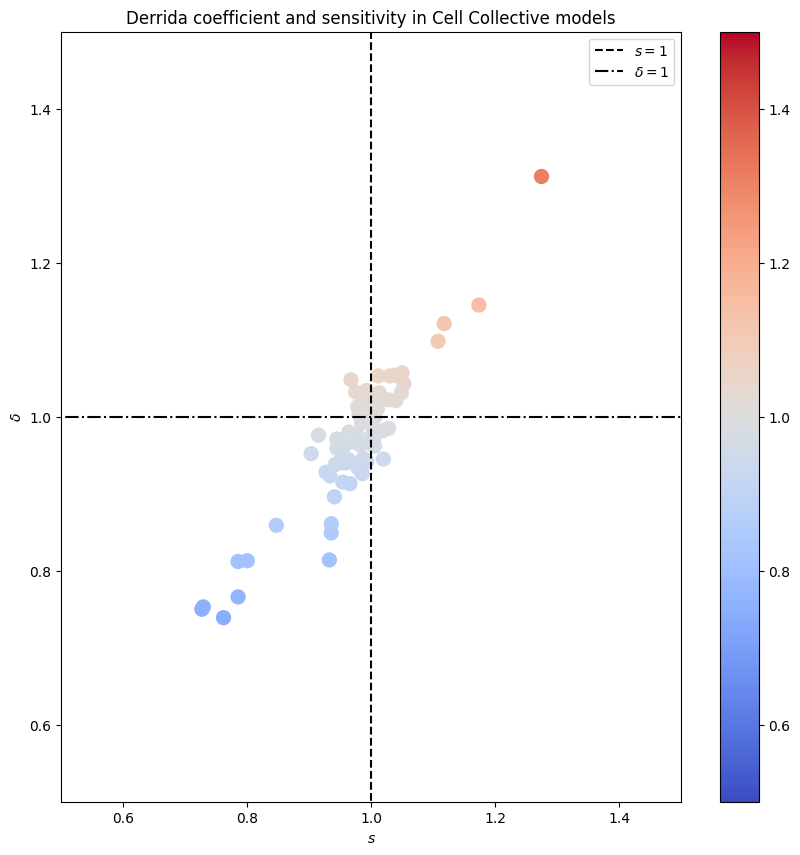

In [13]:
fig, ax = plt.subplots(figsize=(10, 10),facecolor='white')
ax.set_facecolor('white')
varx = 's'
vary = 'dc'
cmap = plt.cm.get_cmap('coolwarm')#.reversed()
sc=ax.scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax.vlines(1.0,0,2,label='$s=1$',color='k',linestyles='--')
ax.hlines(1.0,0,2,label='$\delta=1$',color='k',linestyles='-.')
ax.set_ylim(0.5,1.5)
ax.set_xlim(0.5,1.5)
plt.colorbar(sc)
plt.xlabel('$s$')
plt.ylabel('$\delta$')
plt.title('Derrida coefficient and sensitivity in Cell Collective models')
plt.legend()
plt.savefig(f'figures/DerridaSensitivity_CC.pdf',bbox_inches='tight')
plt.savefig(f'figures/DerridaSensitivity_CC.png',bbox_inches='tight')
plt.show()

#### We show the dependence of $\delta$ on the connectivity-spread products considered earlier.
We highlight a critical region between dotted lines. This region is centered on $\delta=1$ and has width equal to the width of the IQR of the $\delta$ distribution.

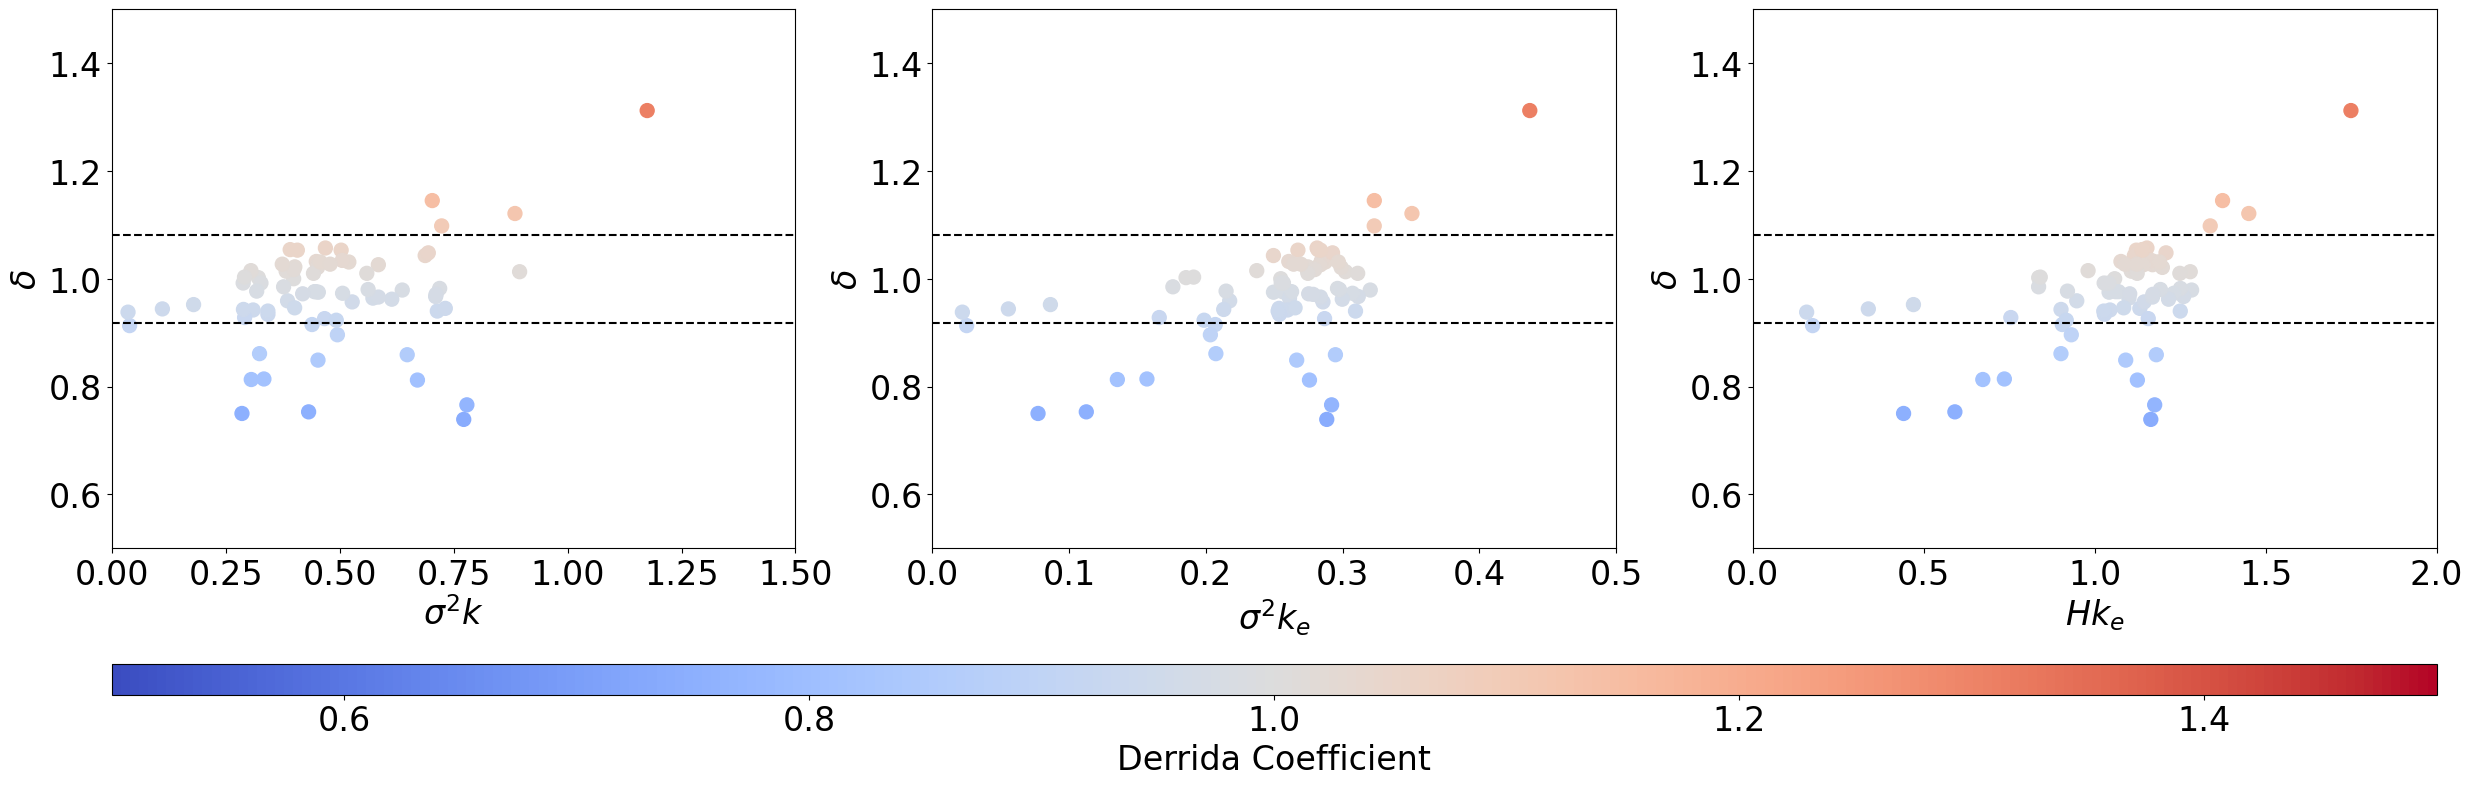

In [14]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
cmap = plt.cm.get_cmap('coolwarm')

dd=np.subtract(*np.percentile(dfcc['dc'], [75, 25]))
sc=ax[0].scatter(dfcc['avgV']*dfcc['k'],dfcc['dc'],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax[0].set_ylim(0.5,1.5)
ax[0].set_xlim(0,1.5)
#ax[0].legend(loc='upper left',fontsize=fs)
ax[0].set_xlabel('$\sigma^2 k$',fontsize=fs)
ax[0].set_ylabel('$\delta$',fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs)
ax[0].hlines([1-dd,1+dd],xmin=0,xmax=1.5,colors='k',linestyles='--')

sc=ax[1].scatter(dfcc['avgV']*dfcc['ke'],dfcc['dc'],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax[1].set_ylim(0.5,1.5)
ax[1].set_xlim(0,0.5)
#ax[1].legend(loc='upper left',fontsize=fs)
ax[1].set_xlabel('$\sigma^2 k_e$',fontsize=fs)
ax[1].set_ylabel('$\delta$',fontsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=fs)
ax[1].hlines([1-dd,1+dd],xmin=0,xmax=0.5,colors='k',linestyles='--')

sc=ax[2].scatter(dfcc['avgH']*dfcc['ke'],dfcc['dc'],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
ax[2].set_ylim(0.5,1.5)
ax[2].set_xlim(0,2)
#ax[2].legend(loc='upper left',fontsize=fs)
ax[2].set_xlabel('$H k_e$',fontsize=fs)
ax[2].set_ylabel('$\delta$',fontsize=fs)
ax[2].tick_params(axis='both', which='major', labelsize=fs)
ax[2].hlines([1-dd,1+dd],xmin=0,xmax=2,colors='k',linestyles='--')

cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.ax.tick_params(axis='both',labelsize=fs)
cbar.set_label('Derrida Coefficient',fontsize=fs)

plt.savefig(f'figures/DerridaConnectivitySpread_CC.pdf',bbox_inches='tight')
plt.savefig(f'figures/DerridaConnectivitySpread_CC.png',bbox_inches='tight')
plt.show()


#### We fit power law functions to the above distributions.
We plot the resulting critical boundary fits in the connectivity-spread planes alongside the corresponding fits obtained for the $N=50$ RBNs. We choose $N=50$ because it is close to the average size of the Cell Collective models. Notably, the $\sigma^2 k$ fit is quite poor, prompting us to consider a linear fit instead.

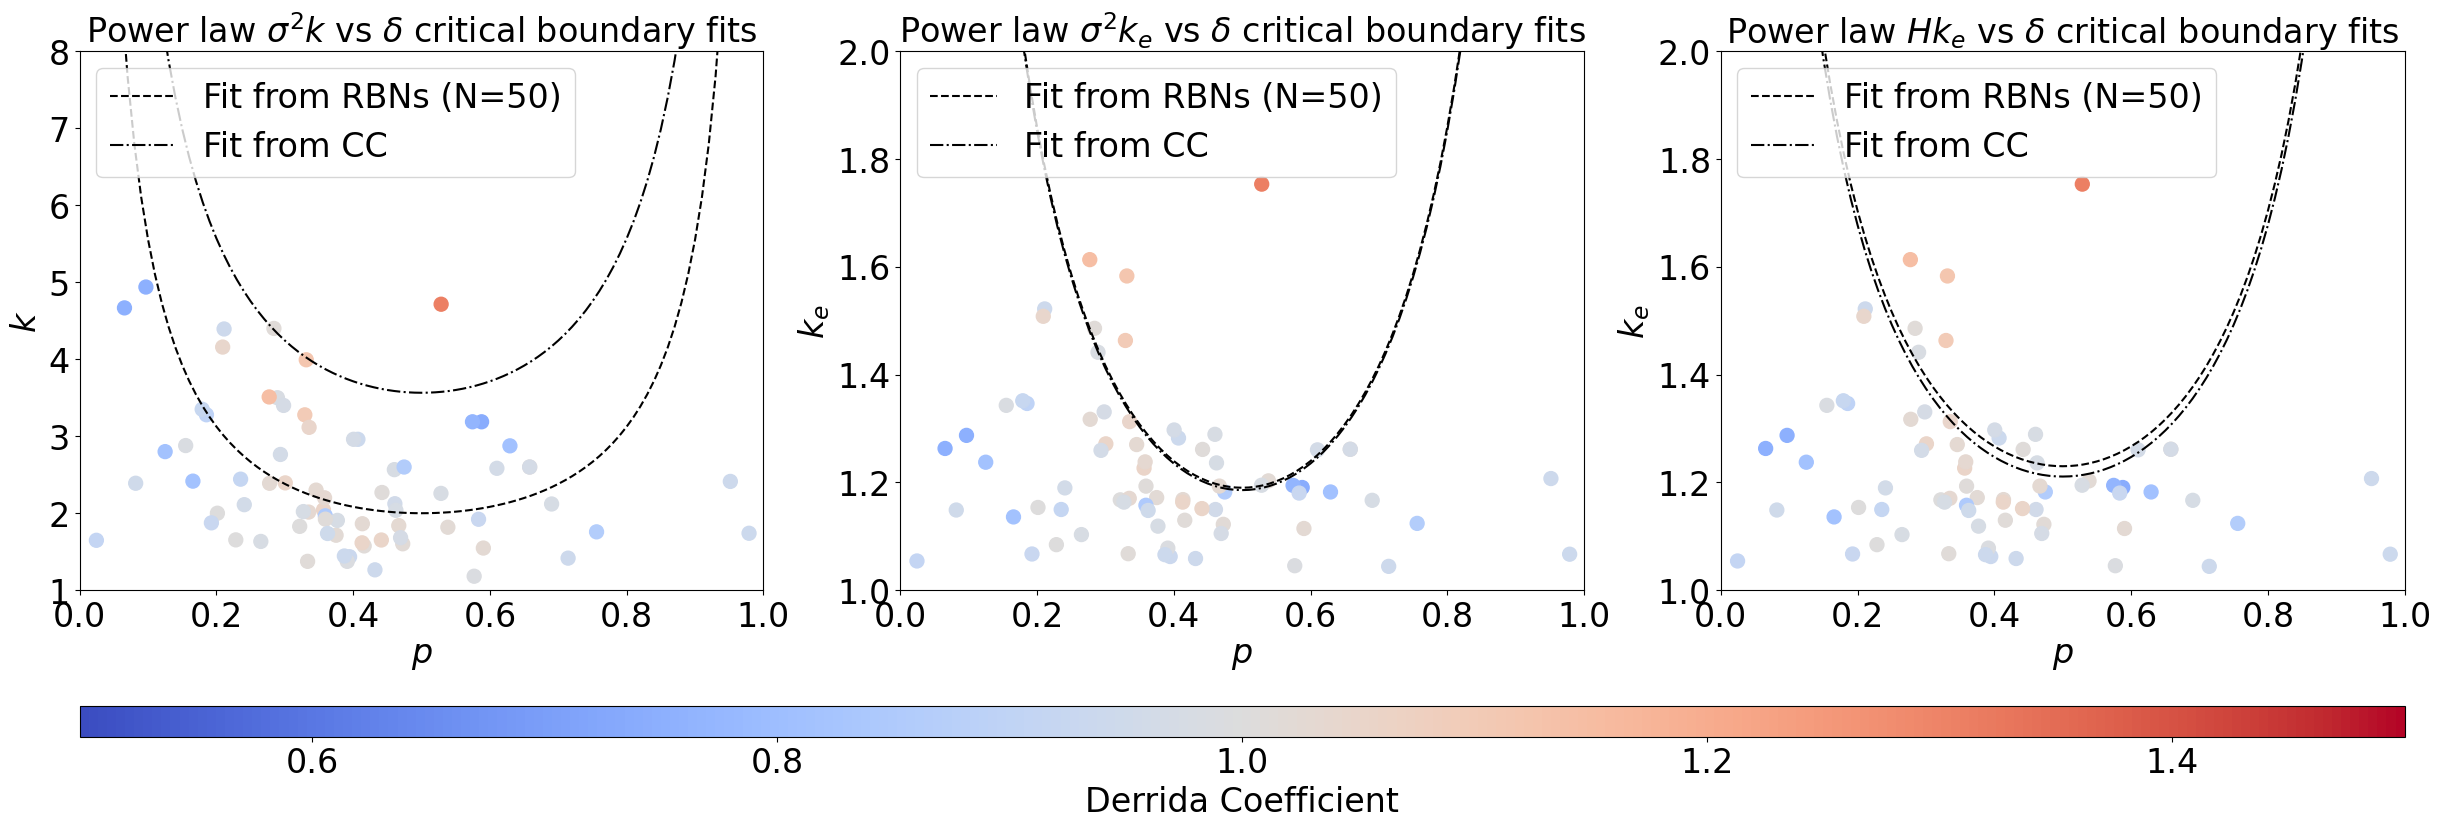

In [15]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
bounds = ([0,0,-10],[10,10,10]) #c,m,b
fs = 24
cmap = plt.cm.get_cmap('coolwarm')

varx = 'bias'
vary = 'k'

popt, pcov = curve_fit(powerlaw,dfcc['k']*dfcc['avgV'],dfcc['dc'],bounds=bounds,p0=[2,1,0])
c, m, b = popt
sc=ax[0].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
px = np.arange(0.01,1,0.01)
py=critical_kappa(px*(1-px),c,m,b)
py2=critical_kappa(px*(1-px),2,1,0)
ax[0].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[0].plot(px,py,'-.k',label='Fit from CC')
ax[0].set_ylim(1,8)
ax[0].set_xlim(0,1)
ax[0].legend(loc='upper left',fontsize=fs)
ax[0].set_xlabel('$p$',fontsize=fs)
ax[0].set_ylabel('$k$',fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs)
ax[0].set_title('Power law $\sigma^2 k$ vs $\delta$ critical boundary fits',fontsize=fs)

varx = 'bias'
vary = 'ke'

popt, pcov = curve_fit(powerlaw,dfcc['ke']*dfcc['avgV'],dfcc['dc'],bounds=bounds,p0=[2.4,0.8,0.09])
c, m, b = popt
sc=ax[1].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
px = np.arange(0.01,1,0.01)
py=critical_kappa(px*(1-px),c,m,b)
py2=critical_kappa(px*(1-px),2.4,0.8,0.09)
ax[1].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[1].plot(px,py,'-.k',label='Fit from CC')
ax[1].set_ylim(1,2)
ax[1].set_xlim(0,1)
ax[1].legend(loc='upper left',fontsize=fs)
ax[1].set_xlabel('$p$',fontsize=fs)
ax[1].set_ylabel('$k_e$',fontsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=fs)
ax[1].set_title('Power law $\sigma^2 k_e$ vs $\delta$ critical boundary fits',fontsize=fs)

varx = 'bias'
vary = 'ke'
popt, pcov = curve_fit(powerlaw,dfcc['ke']*dfcc['avgH'],dfcc['dc'],bounds=bounds,p0=[0.8,0.83,0.05])
c, m, b = popt
sc=ax[2].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0,label=None)
px = np.arange(0.01,1,0.01)
pH = -px*np.log2(px)-(1-px)*np.log2(1-px)
py=critical_kappa(pH,c,m,b)
py2=critical_kappa(pH,0.8,0.83,0.05)
ax[2].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[2].plot(px,py,'-.k',label='Fit from CC')
ax[2].set_ylim(1,2)
ax[2].set_xlim(0,1)
ax[2].legend(loc='upper left',fontsize=fs)
ax[2].set_xlabel('$p$',fontsize=fs)
ax[2].set_ylabel('$k_e$',fontsize=fs)
ax[2].tick_params(axis='both', which='major', labelsize=fs)
ax[2].set_title('Power law $H k_e$ vs $\delta$ critical boundary fits',fontsize=fs)

cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.ax.tick_params(axis='both',labelsize=fs)
cbar.set_label('Derrida Coefficient',fontsize=fs)

plt.savefig(f'figures/PowerLawFits_CC.pdf',bbox_inches='tight')
plt.savefig(f'figures/PowerLawFits_CC.png',bbox_inches='tight')
plt.show()

#### We also consider a linear fit instead of a power law fit.
In the RBN data, we exclude $\delta\lt 0.5$. In the Cell Collective data, no network has $\delta\lt 0.5$.


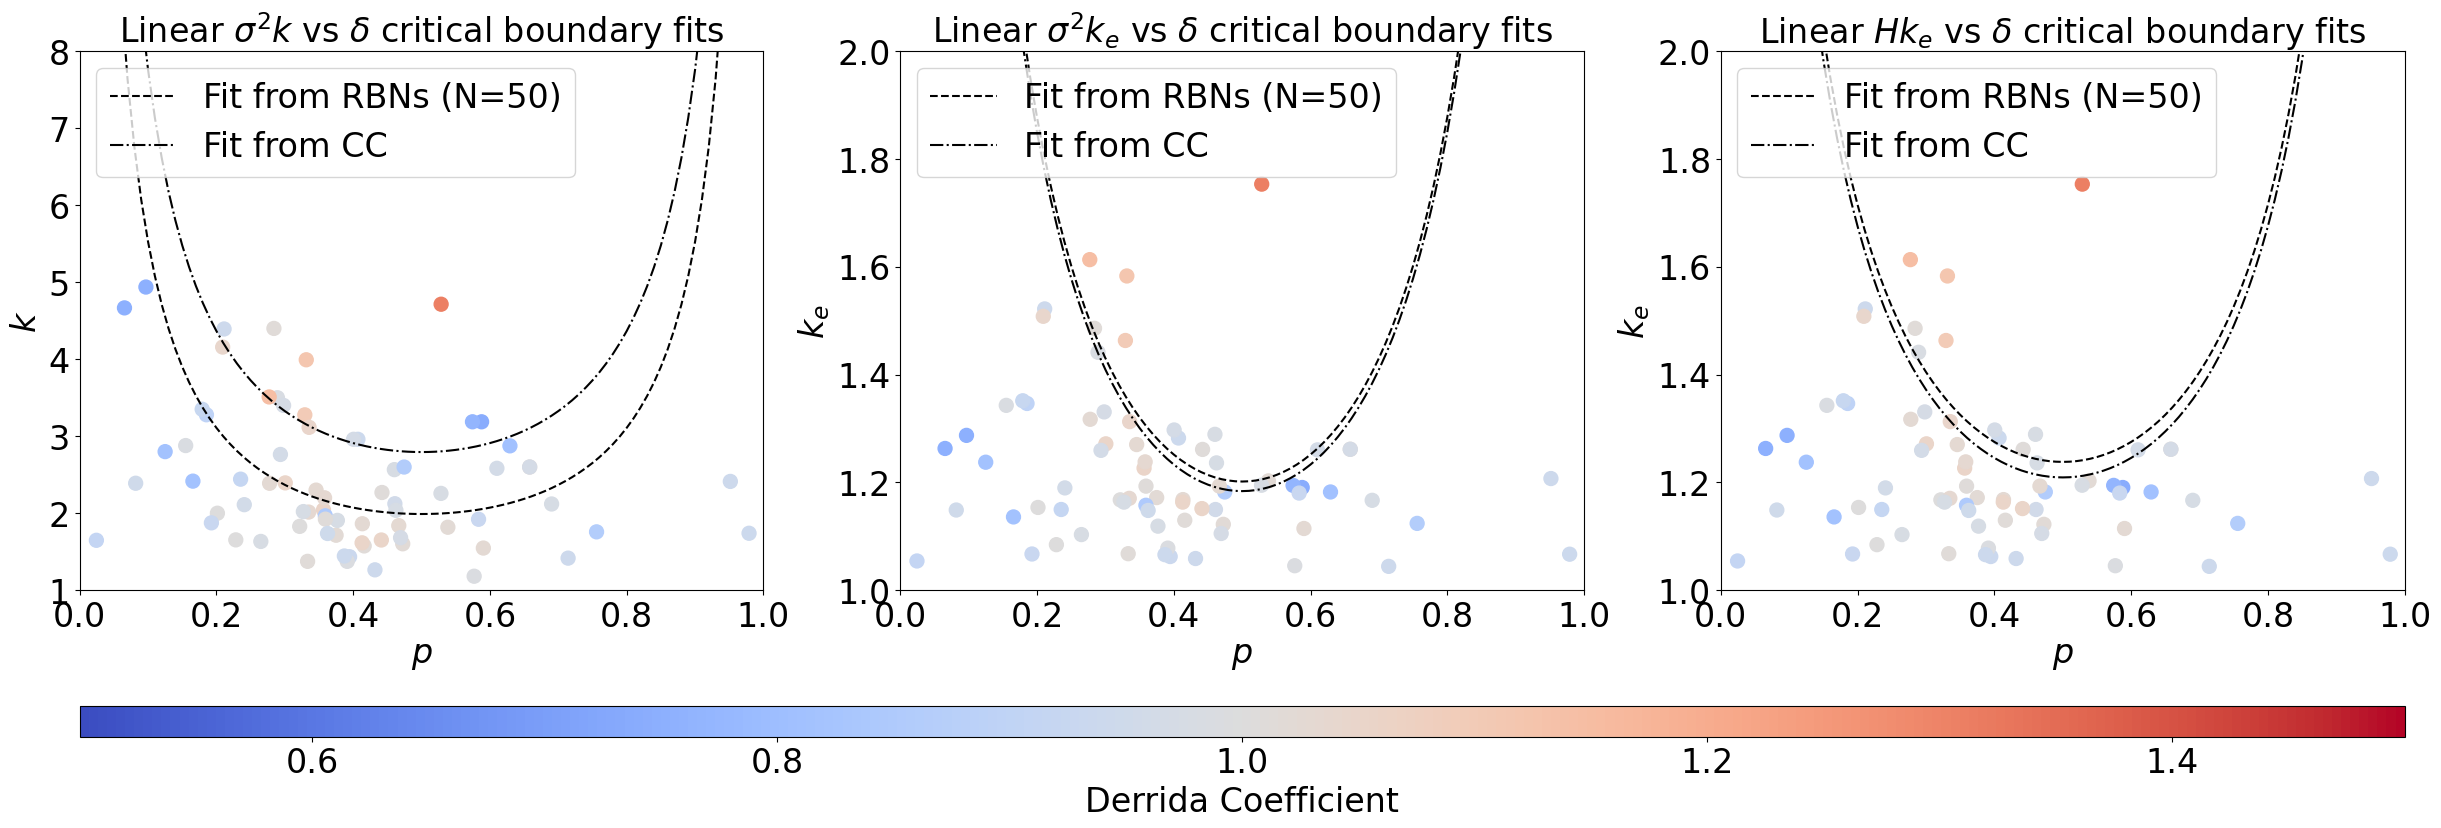

In [16]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),facecolor='white')
bounds = ([0,0,-0.1],[10,2,0.1]) #c,m,b
fs = 24
cmap = plt.cm.get_cmap('coolwarm')#.reversed()

varx = 'bias'
vary = 'k'

popt, pcov = curve_fit(linear_law,dfcc['k']*dfcc['avgV'],dfcc['dc'])
m, b = popt
sc=ax[0].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
px = np.arange(0.01,1,0.01)
py=critical_kappa_lin(px*(1-px),m,b)
py2=critical_kappa_lin(px*(1-px),1.95,0.03)
ax[0].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[0].plot(px,py,'-.k',label='Fit from CC')
ax[0].set_ylim(1,8)
ax[0].set_xlim(0,1)
ax[0].legend(loc='upper left',fontsize=fs)
ax[0].set_xlabel('$p$',fontsize=fs)
ax[0].set_ylabel('$k$',fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs)
ax[0].set_title('Linear $\sigma^2 k$ vs $\delta$ critical boundary fits',fontsize=fs)

varx = 'bias'
vary = 'ke'

popt, pcov = curve_fit(linear_law,dfcc['ke']*dfcc['avgV'],dfcc['dc'])
m, b = popt
sc=ax[1].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0)
px = np.arange(0.01,1,0.01)
py=critical_kappa_lin(px*(1-px),m,b)
py2=critical_kappa_lin(px*(1-px),2.43,0.27)
ax[1].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[1].plot(px,py,'-.k',label='Fit from CC')
ax[1].set_ylim(1,2)
ax[1].set_xlim(0,1)
ax[1].legend(loc='upper left',fontsize=fs)
ax[1].set_xlabel('$p$',fontsize=fs)
ax[1].set_ylabel('$k_e$',fontsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=fs)
ax[1].set_title('Linear $\sigma^2 k_e$ vs $\delta$ critical boundary fits',fontsize=fs)

varx = 'bias'
vary = 'ke'

popt, pcov = curve_fit(linear_law,dfcc['ke']*dfcc['avgH'],dfcc['dc'])
m, b = popt
sc=ax[2].scatter(dfcc[varx],dfcc[vary],s=100,c=dfcc['dc'],cmap=cmap,
              norm=CenteredNorm(vcenter=1,halfrange=0.5),alpha=1.0,label=None)
px = np.arange(0.01,1,0.01)
pH = -px*np.log2(px)-(1-px)*np.log2(1-px)
py=critical_kappa_lin(pH,m,b)
py2=critical_kappa_lin(pH,0.63,0.22)
ax[2].plot(px,py2,'--k',label='Fit from RBNs (N=50)')
ax[2].plot(px,py,'-.k',label='Fit from CC')
ax[2].set_ylim(1,2)
ax[2].set_xlim(0,1)
ax[2].legend(loc='upper left',fontsize=fs)
ax[2].set_xlabel('$p$',fontsize=fs)
ax[2].set_ylabel('$k_e$',fontsize=fs)
ax[2].tick_params(axis='both', which='major', labelsize=fs)
ax[2].set_title('Linear $H k_e$ vs $\delta$ critical boundary fits',fontsize=fs)

cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.ax.tick_params(axis='both',labelsize=fs)
cbar.set_label('Derrida Coefficient',fontsize=fs)

plt.savefig(f'figures/LinearFits_CC.pdf',bbox_inches='tight')
plt.savefig(f'figures/LinearFits_CC.png',bbox_inches='tight')
plt.show()

#### We now examine how well the critical regions predicted by the fits agree with that obtained from $\delta$ directly.
The critical region here is taken to be the range of $\delta$ values (predicted or measured) that is centered at $\delta=1$ and has width equal to the IQR of the $\delta$ distribution (predicted or measured). In all cases, we consider the linear fits.

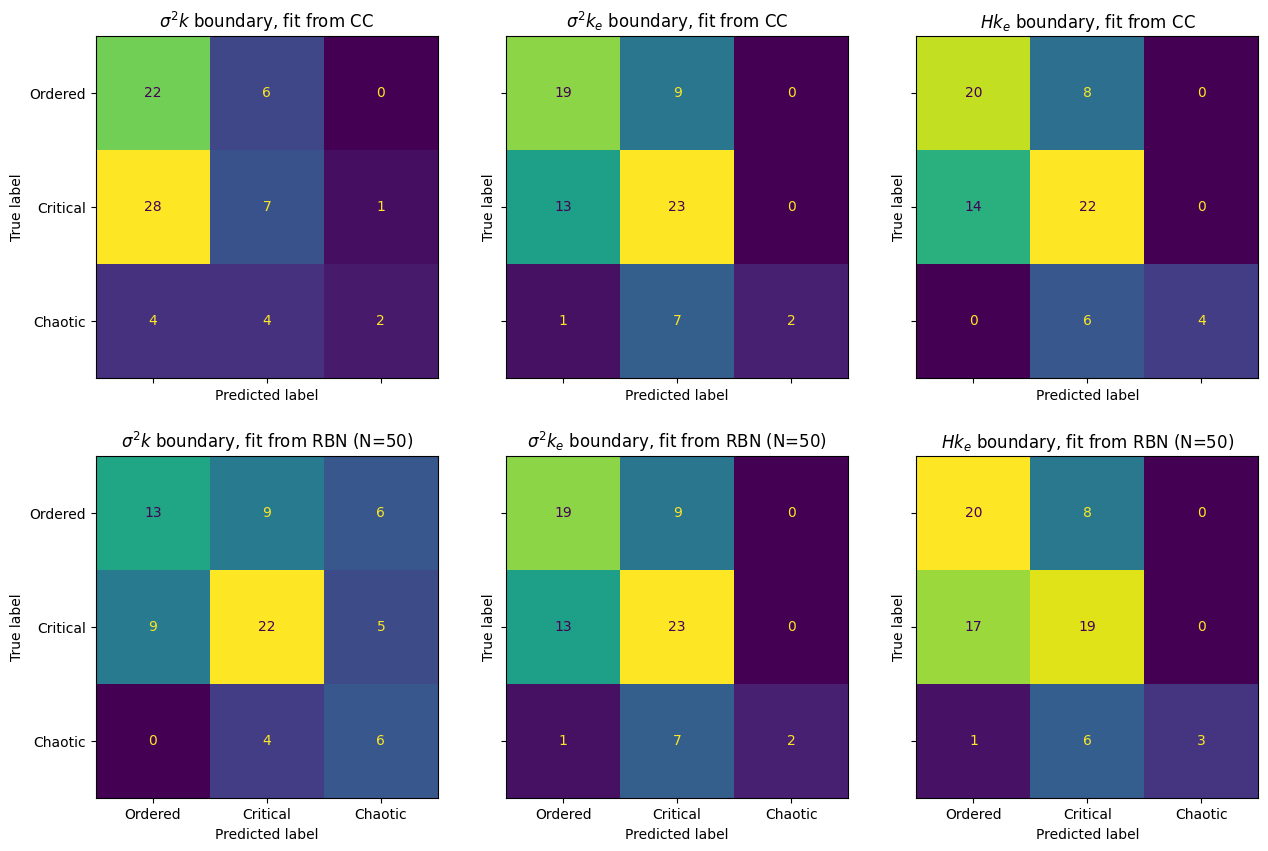

In [17]:
fs = 24

dev_frac = 2
critical_range = np.subtract(*np.percentile(dfcc['dc'], [75, 25]))/dev_frac#dfcc['dc'].std()/dev_frac  
truth = (dfcc['dc'] > (1+critical_range)).astype(int) - \
    (dfcc['dc'] < (1-critical_range)).astype(int)

fig, ax = plt.subplots(2, 3, figsize=(
    15, 10), sharey='row', sharex='col', facecolor='white')

x = dfcc['k']*dfcc['avgV']
popt, pcov = curve_fit(linear_law,dfcc['k']*dfcc['avgV'],dfcc['dc'])
m, b = popt
yfit = linear_law(x, m, b)
critical_range = np.subtract(*np.percentile(yfit, [75, 25]))/dev_frac#yfit.std()/dev_frac
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[0, 0])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$\sigma^2 k$ boundary, fit from CC'
ax[0, 0].set_title(label)

x = dfcc['ke']*dfcc['avgV']
popt, pcov = curve_fit(linear_law,dfcc['ke']*dfcc['avgV'],dfcc['dc'])
m, b = popt
yfit = linear_law(x, m, b)
critical_range = np.subtract(*np.percentile(yfit, [75, 25]))/dev_frac#yfit.std()/dev_frac
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[0, 1])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$\sigma^2 k_e$ boundary, fit from CC'
ax[0, 1].set_title(label)

x = dfcc['ke']*dfcc['avgH']
popt, pcov = curve_fit(linear_law,dfcc['ke']*dfcc['avgH'],dfcc['dc'])
m, b = popt
yfit = linear_law(x, m, b)
critical_range = np.subtract(*np.percentile(yfit, [75, 25]))/dev_frac#yfit.std()/dev_frac
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[0, 2])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$H k_e$ boundary, fit from CC'
ax[0, 2].set_title(label)

x = dfcc['k']*dfcc['avgV']
c, m, b = (2, 1, 0)
yfit = powerlaw(x, c, m, b)
critical_range = np.subtract(*np.percentile(yfit, [75, 25]))/dev_frac#yfit.std()/dev_frac
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[1, 0])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$\sigma^2 k$ boundary, fit from RBN (N=50)'
ax[1, 0].set_title(label)

x = dfcc['ke']*dfcc['avgV']
c, m, b = (2.4, 0.8, 0.09)
yfit = powerlaw(x, c, m, b)
critical_range = np.subtract(*np.percentile(yfit, [75, 25]))/dev_frac#yfit.std()/dev_frac
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[1, 1])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$\sigma^2 k_e$ boundary, fit from RBN (N=50)'
ax[1, 1].set_title(label)

x = dfcc['ke']*dfcc['avgH']
c, m, b = (0.8, 0.83, 0.05)
yfit = powerlaw(x, c, m, b)
critical_range = np.subtract(*np.percentile(yfit, [75, 25]))/dev_frac#yfit.std()/dev_frac
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit < (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Critical', 'Chaotic'])
cm_display.plot(ax=ax[1, 2])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$H k_e$ boundary, fit from RBN (N=50)'
ax[1, 2].set_title(label)

plt.savefig(f'figures/LinearConfusionIQR_CC.pdf',bbox_inches='tight')
plt.savefig(f'figures/LinearConfusionIQR_CC.png',bbox_inches='tight')
plt.show()


#### We reproduce the above figure, but now consider only two categories: $\delta\leq 1$ (Ordered/Critical) and $\delta\gt 1$ (Chaotic)

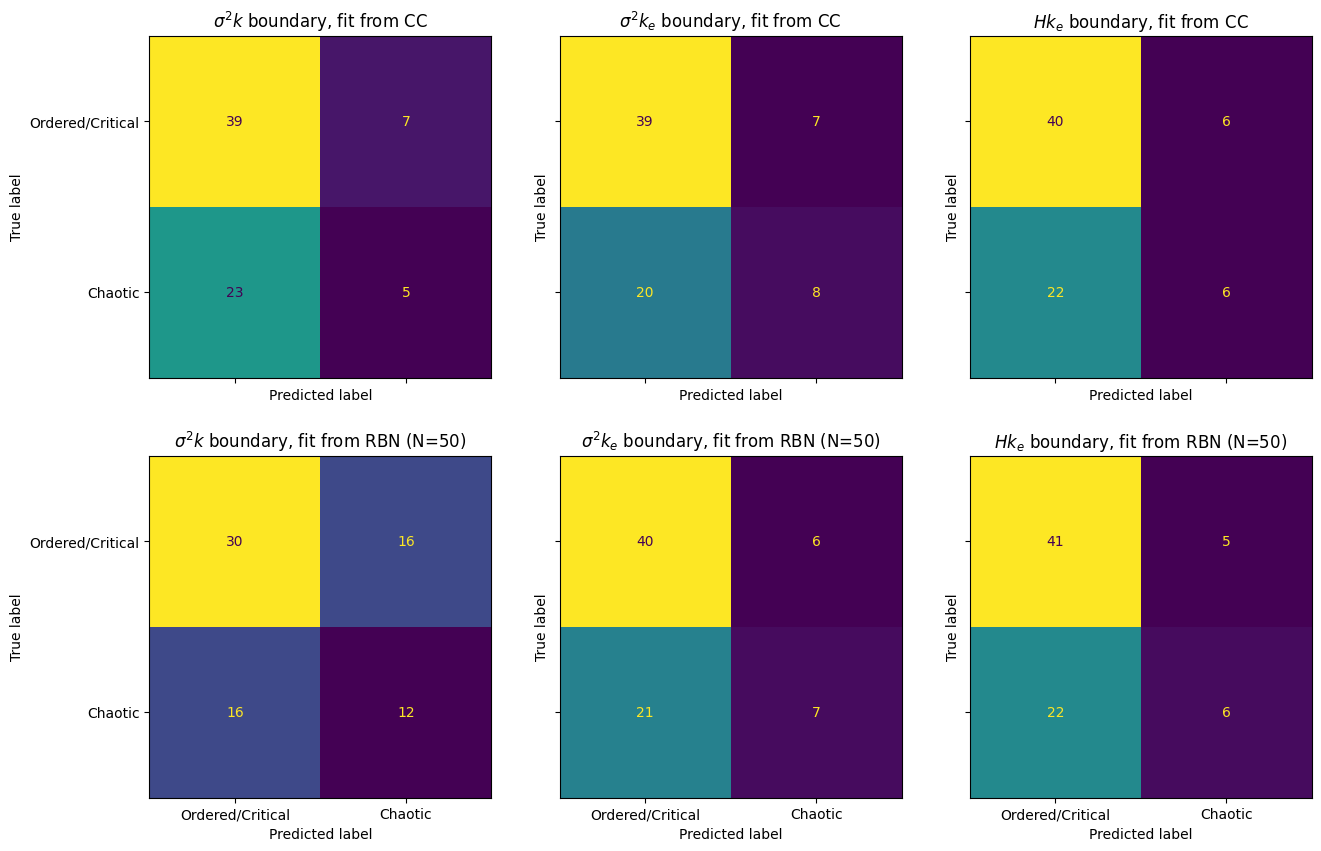

In [18]:
fs = 24

critical_range = 0
truth = (dfcc['dc'] > (1+critical_range)).astype(int) - \
    (dfcc['dc'] <= (1-critical_range)).astype(int)

fig, ax = plt.subplots(2, 3, figsize=(
    15, 10), sharey='row', sharex='col', facecolor='white')

x = dfcc['k']*dfcc['avgV']
popt, pcov = curve_fit(linear_law,dfcc['k']*dfcc['avgV'],dfcc['dc'])
m, b = popt
yfit = linear_law(x, m, b)
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit <= (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered', 'Chaotic'])
cm_display.plot(ax=ax[0, 0])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$\sigma^2 k$ boundary, fit from CC'
ax[0, 0].set_title(label)

x = dfcc['ke']*dfcc['avgV']
popt, pcov = curve_fit(linear_law,dfcc['ke']*dfcc['avgV'],dfcc['dc'])
m, b = popt
yfit = linear_law(x, m, b)
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit <= (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered/Critical', 'Chaotic'])
cm_display.plot(ax=ax[0, 1])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$\sigma^2 k_e$ boundary, fit from CC'
ax[0, 1].set_title(label)

x = dfcc['ke']*dfcc['avgH']
popt, pcov = curve_fit(linear_law,dfcc['ke']*dfcc['avgH'],dfcc['dc'])
m, b = popt
yfit = linear_law(x, m, b)
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit <= (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered/Critical', 'Chaotic'])
cm_display.plot(ax=ax[0, 2])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$H k_e$ boundary, fit from CC'
ax[0, 2].set_title(label)

x = dfcc['k']*dfcc['avgV']
c, m, b = (2, 1, 0)
yfit = powerlaw(x, c, m, b)
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit <= (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered/Critical', 'Chaotic'])
cm_display.plot(ax=ax[1, 0])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$\sigma^2 k$ boundary, fit from RBN (N=50)'
ax[1, 0].set_title(label)

x = dfcc['ke']*dfcc['avgV']
c, m, b = (2.4, 0.8, 0.09)
yfit = powerlaw(x, c, m, b)
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit <= (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered/Critical', 'Chaotic'])
cm_display.plot(ax=ax[1, 1])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$\sigma^2 k_e$ boundary, fit from RBN (N=50)'
ax[1, 1].set_title(label)

x = dfcc['ke']*dfcc['avgH']
c, m, b = (0.8, 0.83, 0.05)
yfit = powerlaw(x, c, m, b)
preds = (yfit > (1+critical_range)).astype(int) - \
    (yfit <= (1-critical_range)).astype(int)
confusion_matrix = metrics.confusion_matrix(truth, preds)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=['Ordered/Critical', 'Chaotic'])
cm_display.plot(ax=ax[1, 2])
cm_display.im_.colorbar.remove()
mstr = '{'+str(np.round(m, 2))+'}'
label = f'$H k_e$ boundary, fit from RBN (N=50)'
ax[1, 2].set_title(label)

plt.savefig(f'figures/LinearConfusionSharp_CC.pdf',bbox_inches='tight')
plt.savefig(f'figures/LinearConfusionSharp_CC.png',bbox_inches='tight')
plt.show()